# Client 2 Gas

### Imports

In [1]:
import sys
import warnings
import os.path
import statistics
import math
sys.path.insert(0, os.path.abspath('../../../../functions'))
from knmi_weather import knmi_weather as knmi # eda tools
from sp_ql import Engine
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from matplotlib.dates import DateFormatter
from math import ceil
import datetime as dt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV, KFold
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import RepeatedKFold
import joblib
import seaborn as sns
import xgboost
from xgboost import XGBRegressor

### Defs

In [2]:
def calc_soc_pos_on_plot(df_compare_monthly, soc):
    sm = list(df_compare_monthly.index < soc).index(False) # first False is start month
    return sm - 0.5 # place of dashed line on plot in 0-1 x coord range

### Read Inputs

In [ ]:
project = 'MERIN'
engine=Engine(project=project, isAsync=False)
bms_registers = engine.list().filter(unit='CELCIUS').all()
build_names = bms_registers['keyname_01'].unique()
build_names = build_names[~pd.isna(build_names)]
eans=pd.read_csv(f'/Users/Matt/Desktop/MSc/Thesis/Spectral/brighter_eda/inputs/eans/{project.lower()}_eans.csv')
gas_eans=eans[eans['Contract Type']=='Natural Gas']
gas_eans=gas_eans[['keyname_01', 'EAN']].dropna().set_index('keyname_01').squeeze()

adds missing buildings
for building in build_names:
    if building not in gas_eans.index:
        gas_eans[building]=np.nan
#nodata
del gas_eans['VOGELSTR']
del gas_eans['AQUARIUS']
del gas_eans['SPICALN1']
del gas_eans['HBW1ADAM']
del gas_eans['TRW32ADM']
del gas_eans['TUPLEV65']
del gas_eans['KRSD8ADM']
#missing or gappy data
del gas_eans['HGHW4ADM']
del gas_eans['OVSAM184']
socs = pd.read_csv(r'/Users/Matt/Desktop/MSc/Thesis/Spectral/brighter_eda/inputs/start_of_control/start_of_control_dates.csv')
socs = socs[socs['project']==project]
socs = socs.set_index('keyname_01')['soc_date'].squeeze()
socs = pd.to_datetime(socs)

In [64]:
build_names=np.delete(build_names, 10, axis=None) #no gas or electr data

In [65]:
# determine building location
cities = eans[['keyname_01', 'City']].dropna()
cities = cities.drop_duplicates().set_index('keyname_01').squeeze()
cities['P163063']='Amsterdam' #manually adding: Derkinderenstraat=P163063=Amsterdam
cities = cities[gas_eans.index]

# read and preprocess weather data
knmi_station_lookup = pd.read_csv(r'../../../../inputs/knmi/knmi_uurgegevens/city_knmi_station_lookup.csv', index_col=0, squeeze=True)

In [66]:
weather = {}
for station in knmi_station_lookup.unique():
    knmi_weather_file_1 = f'../../../../inputs/knmi/knmi_uurgegevens/uurgeg_{station}_2011-2020.txt'
    knmi_weather_file_2 = f'../../../../inputs/knmi/knmi_uurgegevens/uurgeg_{station}_2021-2030.txt'
    knmi_weather = pd.read_csv(knmi_weather_file_1,
                               skiprows=31,
                               skipinitialspace=True,
                               usecols=list(range(1, 25)))
    knmi_weather = knmi_weather.append(pd.read_csv(knmi_weather_file_2,
                                                   skiprows=31,
                                                   skipinitialspace=True,
                                                   usecols=list(range(1, 25))))
    # making proper index for KNMI weather data
    knmi_weather.index = knmi.convert_knmi_dates(date=knmi_weather['YYYYMMDD'],
                                                 hour=knmi_weather['HH'])
    # clean up values
    knmi_weather = knmi.cleanup_knmi_units(knmi_weather=knmi_weather)
    weather[station] = knmi_weather

In [67]:
## Determine training and prediction intervals
train_periods = pd.DataFrame()
train_periods['end'] = socs[gas_eans.index]
train_periods['start'] = socs[gas_eans.index] - dt.timedelta(days=365) #more training data=better

In [68]:
## prepare features and training data:
# get and save training gas use data locally (no need to do this every time)
engine = Engine(project=project, isAsync=False)
time_res = 'd'
gas_use_train = pd.DataFrame(index=pd.date_range(start=train_periods['start'].min(),
                                                 end=train_periods['end'].max(),
                                                 freq=time_res))

# data from sp-ql
for building in gas_eans.index:
    # get gas use
    start_train = train_periods.loc[building, 'start']
    end_train = train_periods.loc[building, 'end']
    gas_ean = gas_eans[building]
    gas_use = engine.select(gas_ean).group_by(time_res).sum().after(start_train).before(end_train).all()
    gas_use = gas_use.rename(columns={gas_use.columns[0]:building})
    gas_use_train = gas_use_train.join(gas_use)
gas_use_train.to_csv(r'MERIN_gas/data/gas_use_train.csv')

In [69]:
gas_use_train = pd.read_csv(r'MERIN_gas/data/gas_use_train.csv', index_col=0,
                            parse_dates=True)

In [70]:
# some buildings have small gaps in gas data. We can interpolate over these
for building in gas_eans.index:
    start_train = train_periods.loc[building, 'start']
    end_train = train_periods.loc[building, 'end']
    gas_use_train_build = gas_use_train.loc[start_train:end_train, building]
    # setting first element to 0 if nan. To aid interpolation.
    if gas_use_train_build.iloc[[0]].isna()[0]:
        gas_use_train_build.iloc[0] = 0
    gas_use_train_build = gas_use_train_build.interpolate(limit=10) # filling max 10 consecutive days of missing data
    gas_use_train.loc[start_train:end_train, building] = gas_use_train_build
gas_use_train

,CRBA_CAP,CRBB_CAP,GPR_EH,HGHW8ADM,OVSAM186,OVSAM61,POLAR130,WEND_163
2018-03-15,NaN,NaN,674.719971,NaN,NaN,NaN,NaN,NaN
2018-03-16,NaN,NaN,791.640015,NaN,NaN,NaN,NaN,NaN
2018-03-17,NaN,NaN,305.579987,NaN,NaN,NaN,NaN,NaN
2018-03-18,NaN,NaN,479.350006,NaN,NaN,NaN,NaN,NaN
2018-03-19,NaN,NaN,1374.670044,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...
2021-12-13,NaN,496.307404,NaN,NaN,NaN,NaN,NaN,NaN
2021-12-14,NaN,512.312988,NaN,NaN,NaN,NaN,NaN,NaN
2021-12-15,NaN,442.898102,NaN,NaN,NaN,NaN,NaN,NaN
2021-12-16,NaN,416.780701,NaN,NaN,NaN,NaN,NaN,NaN


### RF model

In [71]:
for building in gas_eans.index:
    print(fr'Training building {building}, {gas_eans.index.get_loc(building) + 1}/{len(gas_eans)}')
    city = cities[building]
    knmi_station = knmi_station_lookup[city]
    knmi_weather = weather[knmi_station]
    start_train = train_periods.loc[building, 'start']
    end_train = train_periods.loc[building, 'end']
    #
    features = pd.DataFrame()
    features['daily_mean_OAT'] = knmi_weather['T'].resample('d').mean()
    features['daily_sum_GHI'] = knmi_weather['Q'].resample('d').sum()
    features['dow'] = features.index.dayofweek
    #features['month'] = features.index.month
    #
    gas_use_train_build = gas_use_train[building]
    # X: training features, y: training target
    X = features[(features.index >= start_train) & (features.index < end_train)]
    y = gas_use_train_build[(gas_use_train_build.index >= start_train) &
                            (gas_use_train_build.index < end_train)]
    #
    # checking if there is any nan in the data
    if X.isna().sum().sum() + y.isna().sum() > 0:
        raise ValueError('NaN in training data:', building)
    #
    # checking on dependency of taget on features to get a feel
    if False:
        fig, ax = plt.subplots(len(X.columns), 1)
        for i, c in enumerate(X.columns):
            ax[i].scatter(x=X[c], y=y)
            ax[i].set_title(c)
        plt.show(block=False)
    #
    # make train-test split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)
    #
    # grid-search for hyper parameter tuning
    param_grid = {'max_depth': [2, 5, 10, 20, 50, 100],
                  'min_samples_leaf': [1, 5, 10],
                  'n_estimators': [500]}
    rf = RandomForestRegressor()
    grid_search = GridSearchCV(estimator=rf, param_grid=param_grid,
                               cv=KFold(10, shuffle=True), n_jobs=-1, verbose=False)
    grid_search.fit(X_train, y_train)
    #
    # save the trained RF
    joblib.dump(grid_search.best_estimator_, fr'MERIN_gas/data/trained_models/rf/trained_{building}.joblib')
    joblib.dump(X_test, fr'MERIN_gas/data/trained_models/rf/X_test_{building}.joblib')
    joblib.dump(y_test, fr'MERIN_gas/data/trained_models/rf/y_test_{building}.joblib')

Training building CRBA_CAP, 1/8
Training building CRBB_CAP, 2/8
Training building GPR_EH, 3/8
Training building HGHW8ADM, 4/8
Training building OVSAM186, 5/8
Training building OVSAM61, 6/8
Training building POLAR130, 7/8
Training building WEND_163, 8/8


### Gradient Boosting

In [71]:
for building in gas_eans.index:
    print(fr'Training building {building}, {gas_eans.index.get_loc(building) + 1}/{len(gas_eans)}')
    city = cities[building]
    knmi_station = knmi_station_lookup[city]
    knmi_weather = weather[knmi_station]
    start_train = train_periods.loc[building, 'start']
    end_train = train_periods.loc[building, 'end']
    #
    features = pd.DataFrame()
    features['daily_mean_OAT'] = knmi_weather['T'].resample('d').mean()
    features['daily_sum_GHI'] = knmi_weather['Q'].resample('d').sum()
    features['dow'] = features.index.dayofweek
    #features['month'] = features.index.month
    #
    gas_use_train_build = gas_use_train[building]
    # X: training features, y: training target
    X = features[(features.index >= start_train) & (features.index < end_train)]
    y = gas_use_train_build[(gas_use_train_build.index >= start_train) &
                            (gas_use_train_build.index < end_train)]
    #
    # checking if there is any nan in the data
    if X.isna().sum().sum() + y.isna().sum() > 0:
        raise ValueError('NaN in training data:', building)
    #
    # checking on dependency of taget on features to get a feel
    if False:
        fig, ax = plt.subplots(len(X.columns), 1)
        for i, c in enumerate(X.columns):
            ax[i].scatter(x=X[c], y=y)
            ax[i].set_title(c)
        plt.show(block=False)
    #
    # make train-test split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)
    #
    # grid-search for hyper parameter tuning
    param_grid = {
    "learning_rate": [0.01, 0.025, 0.05, 0.075, 0.1, 0.15, 0.2],
    "max_depth":[3,5,8],
    "max_features":["log2", "sqrt"],
    "subsample":[0.5, 0.618, 0.8, 0.85, 0.9, 0.95, 1.0],
    "n_estimators":[10],
    }
    
    rf = GradientBoostingRegressor()
    grid_search = GridSearchCV(estimator=rf, param_grid=param_grid,
                               cv=KFold(10, shuffle=True), n_jobs=-1, verbose=False)
    grid_search.fit(X_train, y_train)
    
    #
    # save the trained RF
    joblib.dump(grid_search.best_estimator_, fr'MERIN_gas/data/trained_models/gb/trained_{building}.joblib')
    joblib.dump(X_test, fr'MERIN_gas/data/trained_models/gb/X_test_{building}.joblib')
    joblib.dump(y_test, fr'MERIN_gas/data/trained_models/gb/y_test_{building}.joblib')

Training building CRBA_CAP, 1/8
Training building CRBB_CAP, 2/8
Training building GPR_EH, 3/8
Training building HGHW8ADM, 4/8
Training building OVSAM186, 5/8
Training building OVSAM61, 6/8
Training building POLAR130, 7/8
Training building WEND_163, 8/8


### XGBoosting

In [121]:
for building in gas_eans.index:
    print(fr'Training building {building}, {gas_eans.index.get_loc(building) + 1}/{len(gas_eans)}')
    city = cities[building]
    knmi_station = knmi_station_lookup[city]
    knmi_weather = weather[knmi_station]
    start_train = train_periods.loc[building, 'start']
    end_train = train_periods.loc[building, 'end']
    features = pd.DataFrame()
    
    features['daily_mean_OAT'] = knmi_weather['T'].resample('d').mean()
    features['daily_sum_GHI'] = knmi_weather['Q'].resample('d').sum()
    features['dow'] = features.index.dayofweek

    gas_use_train_build = gas_use_train[building]
    X = features[(features.index >= start_train) & (features.index < end_train)]
    y = gas_use_train_build[(gas_use_train_build.index >= start_train) &
                            (gas_use_train_build.index < end_train)]
    if X.isna().mean().mean() + y.isna().mean() > 0:
        raise ValueError('NaN in training data:', building)
    if False:
        fig, ax = plt.subplots(len(X.columns), 1)
        for i, c in enumerate(X.columns):
            ax[i].scatter(x=X[c], y=y)
            ax[i].set_title(c)
        plt.show(block=False)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)
    
    
    param_grid={
                "learning_rate": (0.05, 0.10, 0.15, 0.2),
                "max_depth": [3, 4, 5, 6, 8],
                "min_child_weight": [1, 3, 5, 7]
                }

    rf = XGBRegressor()
    cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
    grid_search = GridSearchCV(estimator=rf, param_grid=param_grid,
                               cv=cv, n_jobs=-1, verbose=False)
    grid_search.fit(X_train, y_train)

    joblib.dump(grid_search.best_estimator_, fr'MERIN_gas/data/trained_models/xg/trained_{building}.joblib')
    joblib.dump(X_test, fr'MERIN_gas/data/trained_models/xg/X_test_{building}.joblib')
    joblib.dump(y_test, fr'MERIN_gas/data/trained_models/xg/y_test_{building}.joblib')

Training building CRBA_CAP, 1/8
Training building CRBB_CAP, 2/8
Training building GPR_EH, 3/8
Training building HGHW8ADM, 4/8
Training building OVSAM186, 5/8
Training building OVSAM61, 6/8
Training building POLAR130, 7/8
Training building WEND_163, 8/8


### Metrics

In [72]:
# reading in saved trained RF models and calculating mae for the test set
mae_range_percent = pd.Series()
for building in gas_eans.index:
    models = os.listdir('MERIN_gas/data/trained_models/rf') #change for RF, GB, XG
    if fr'trained_{building}.joblib' in models:
        grid_search = joblib.load(fr'MERIN_gas/data/trained_models/rf/trained_{building}.joblib') #change for RF, GB, XG
        X_test = joblib.load(fr'MERIN_gas/data/trained_models/rf/X_test_{building}.joblib') #change for RF, GB, XG
        y_test = joblib.load(fr'MERIN_gas/data/trained_models/rf/y_test_{building}.joblib') #change for RF, GB, XG
    #
    # grid search already contains the re-trained model with the best parameters
    y_test_pred = grid_search.predict(X_test)
    #
    # calculating MAE and plotting test and pred_test
    mae = mean_absolute_error(y_true=y_test, y_pred=y_test_pred)
    # mae in percent of range
    mae_range_percent[building] = mae / y_test.max() * 100

In [73]:
statistics.mean(mae_range_percent)

5.460624247899692

### Metrics together - MAE

In [74]:
metric_com_mae = pd.DataFrame(index=gas_eans.index)
regressors = ['rf', 'gb', 'xg']
for regressor in regressors:
    mae_range_percent = pd.Series()
    for building in gas_eans.index:
        models = os.listdir(f'MERIN_gas/data/trained_models/{regressor}') #change for RF, GB, XG
        if fr'trained_{building}.joblib' in models:
            grid_search = joblib.load(fr'MERIN_gas/data/trained_models/{regressor}/trained_{building}.joblib') #change for RF, GB, XG
            X_test = joblib.load(fr'MERIN_gas/data/trained_models/{regressor}/X_test_{building}.joblib') #change for RF, GB, XG
            y_test = joblib.load(fr'MERIN_gas/data/trained_models/{regressor}/y_test_{building}.joblib') #change for RF, GB, XG
        #
        # grid search already contains the re-trained model with the best parameters
        y_test_pred = grid_search.predict(X_test)

        #
        # calculating MAE and plotting test and pred_test
        mae = mean_absolute_error(y_true=y_test, y_pred=y_test_pred)
        # mae in percent of range
        mae_range_percent[building] = mae / y_test.max() * 100

        gas_use_train_build = gas_eans[building]

    metric_com_mae[regressor.upper()]=mae_range_percent

### Metrics together - RMSE

In [75]:
metric_com_rmse = pd.DataFrame(index=gas_eans.index)
regressors = ['rf', 'gb', 'xg']
for regressor in regressors:
    rmse_range_percent = pd.Series()
    for building in gas_eans.index:
        models = os.listdir(f'MERIN_gas/data/trained_models/{regressor}') #change for RF, GB, XG
        if fr'trained_{building}.joblib' in models:
            grid_search = joblib.load(fr'MERIN_gas/data/trained_models/{regressor}/trained_{building}.joblib') #change for RF, GB, XG
            X_test = joblib.load(fr'MERIN_gas/data/trained_models/{regressor}/X_test_{building}.joblib') #change for RF, GB, XG
            y_test = joblib.load(fr'MERIN_gas/data/trained_models/{regressor}/y_test_{building}.joblib') #change for RF, GB, XG
        #
        # grid search already contains the re-trained model with the best parameters
        y_test_pred = grid_search.predict(X_test)
        
        #calculating RMSE
        MSE = np.square(np.subtract(y_test, y_test_pred)).mean() 
        RMSE = math.sqrt(MSE)
        rmse_range_percent[building]=RMSE / y_test.max() * 100

    metric_com_rmse[regressor.upper()]=rmse_range_percent

### Stacked ensembling - MAE

In [76]:
en_mae = pd.DataFrame(index=gas_eans.index)
regressors = ['rf', 'gb', 'xg']
mae_range_percent = pd.Series()
master_test=pd.DataFrame()
master_test_pred=pd.DataFrame()

df1=pd.DataFrame()
df2=pd.DataFrame()
df3=pd.DataFrame()
df_c=pd.DataFrame()

df4=pd.DataFrame()
df5=pd.DataFrame()
df6=pd.DataFrame()
df_d=pd.DataFrame()

for building in gas_eans.index:
    for regressor in regressors:
        models = os.listdir(f'MERIN_gas/data/trained_models/{regressor}') #change for RF, GB, XG
        if fr'trained_{building}.joblib' in models:
            grid_search = joblib.load(fr'MERIN_gas/data/trained_models/{regressor}/trained_{building}.joblib') #change for RF, GB, XG
            X_test = joblib.load(fr'MERIN_gas/data/trained_models/{regressor}/X_test_{building}.joblib') #change for RF, GB, XG
            y_test = joblib.load(fr'MERIN_gas/data/trained_models/{regressor}/y_test_{building}.joblib') #change for RF, GB, XG
            #print(y_test) ##gives diffent dates, so needs to be investigated --> tried setting random seed during training
            y_test_pred = grid_search.predict(X_test)
            
            if regressor=="rf":
                df1=y_test.to_frame()
                df4=pd.DataFrame(y_test_pred, columns=[building])
                df1.reset_index(drop=True, inplace=True)
                df4.reset_index(drop=True, inplace=True)
            if regressor=="gb":
                df2=y_test.to_frame()
                df5=pd.DataFrame(y_test_pred, columns=[building])
                df2.reset_index(drop=True, inplace=True)
                df5.reset_index(drop=True, inplace=True)
            if regressor=="xg":
                df3=y_test.to_frame()
                df6=pd.DataFrame(y_test_pred, columns=[building])
                df3.reset_index(drop=True, inplace=True)
                df6.reset_index(drop=True, inplace=True)
                
    df_c=pd.concat([df1, df2, df3], axis=1)
    df_c.columns = [fr'{building}_rf', fr'{building}_gb',fr'{building}_xg']
    df_c[building+"_en"]=(df_c[building+"_rf"]+df_c[building+"_gb"]+df_c[building+"_xg"])/3
    del df_c[building+"_rf"]
    del df_c[building+"_gb"]
    del df_c[building+"_xg"]
    
    df_d=pd.concat([df4, df5, df6], axis=1)
    df_d.columns = [fr'{building}_rf', fr'{building}_gb',fr'{building}_xg']
    df_d[building+"_en"]=(df_d[building+"_rf"]+df_d[building+"_gb"]+df_d[building+"_xg"])/3
    
    del df_d[building+"_rf"]
    del df_d[building+"_gb"]
    del df_d[building+"_xg"]

    mae = mean_absolute_error(y_true=df_c[building+"_en"], y_pred=df_d[building+"_en"])
    
    mae_range_percent[building] = mae / df_c[building+"_en"].max() * 100

    en_mae['EN']=mae_range_percent
    

### Ensemble stacked - MAE

In [77]:
metric_com_mae['EN']=en_mae
print(metric_com_mae)
print("\n")
print("Average MAEs")
round(metric_com_mae.mean(), 5)

                  RF         GB        XG        EN
keyname_01                                         
CRBA_CAP    5.392303  10.540358  6.543824  6.191411
CRBB_CAP    5.098494   8.147705  4.889718  5.307334
GPR_EH      3.319002   6.301563  3.762682  3.641477
HGHW8ADM    5.007882   7.405199  5.453331  5.034317
OVSAM186    7.598128  10.053831  6.463611  8.851068
OVSAM61     6.842367   8.085382  6.401935  5.687001
POLAR130    6.036186   7.938910  7.113832  5.896385
WEND_163    4.390633   7.170075  6.177025  4.932640


Average MAEs


RF    5.46062
GB    8.20538
XG    5.85074
EN    5.69270
dtype: float64

### Stacked ensembling - RMSE

In [78]:
en_rmse = pd.DataFrame(index=gas_eans.index)
regressors = ['rf', 'gb', 'xg']
rmse_range_percent = pd.Series()
master_test=pd.DataFrame()
master_test_pred=pd.DataFrame()

df1=pd.DataFrame()
df2=pd.DataFrame()
df3=pd.DataFrame()
df_c=pd.DataFrame()

df4=pd.DataFrame()
df5=pd.DataFrame()
df6=pd.DataFrame()
df_d=pd.DataFrame()

for building in gas_eans.index:
    for regressor in regressors:
        models = os.listdir(f'MERIN_gas/data/trained_models/{regressor}') #change for RF, GB, XG
        if fr'trained_{building}.joblib' in models:
            grid_search = joblib.load(fr'MERIN_gas/data/trained_models/{regressor}/trained_{building}.joblib') #change for RF, GB, XG
            X_test = joblib.load(fr'MERIN_gas/data/trained_models/{regressor}/X_test_{building}.joblib') #change for RF, GB, XG
            y_test = joblib.load(fr'MERIN_gas/data/trained_models/{regressor}/y_test_{building}.joblib') #change for RF, GB, XG
            #print(y_test) ##gives diffent dates, so needs to be investigated --> tried setting random seed during training
            y_test_pred = grid_search.predict(X_test)
            
            if regressor=="rf":
                df1=y_test.to_frame()
                df4=pd.DataFrame(y_test_pred, columns=[building])
                df1.reset_index(drop=True, inplace=True)
                df4.reset_index(drop=True, inplace=True)
            if regressor=="gb":
                df2=y_test.to_frame()
                df5=pd.DataFrame(y_test_pred, columns=[building])
                df2.reset_index(drop=True, inplace=True)
                df5.reset_index(drop=True, inplace=True)
            if regressor=="xg":
                df3=y_test.to_frame()
                df6=pd.DataFrame(y_test_pred, columns=[building])
                df3.reset_index(drop=True, inplace=True)
                df6.reset_index(drop=True, inplace=True)
                
    df_c=pd.concat([df1, df2, df3], axis=1)
    df_c.columns = [fr'{building}_rf', fr'{building}_gb',fr'{building}_xg']
    df_c[building+"_en"]=(df_c[building+"_rf"]+df_c[building+"_gb"]+df_c[building+"_xg"])/3
    del df_c[building+"_rf"]
    del df_c[building+"_gb"]
    del df_c[building+"_xg"]
    
    df_d=pd.concat([df4, df5, df6], axis=1)
    df_d.columns = [fr'{building}_rf', fr'{building}_gb',fr'{building}_xg']
    df_d[building+"_en"]=(df_d[building+"_rf"]+df_d[building+"_gb"]+df_d[building+"_xg"])/3
    

    MSE = np.square(np.subtract(df_c[building+"_en"], df_d[building+"_en"])).mean() 
    RMSE = math.sqrt(MSE)
    rmse_range_percent[building]=RMSE / df_c[building+"_en"].max() * 100
    
    en_rmse['EN']=rmse_range_percent
    

### Ensemble effort - RMSE

In [79]:
metric_com_rmse['EN']=en_rmse
print(metric_com_rmse)
print("\n")
print("Average RMSEs")
round(metric_com_rmse.mean(), 5)

                   RF         GB         XG         EN
keyname_01                                            
CRBA_CAP     8.135762  13.476156   9.664392   7.977260
CRBB_CAP     7.568542  12.560284   7.430493   7.909329
GPR_EH       4.669324   8.296449   5.137153   4.688618
HGHW8ADM     7.322541  10.069779   7.347634   6.353912
OVSAM186    11.181644  13.039265   8.723654  11.155142
OVSAM61     10.809324  11.341288  10.931397   7.887299
POLAR130     8.268289  10.913334   9.774594   7.358104
WEND_163     6.447655   9.119328   8.393978   6.574048


Average RMSEs


RF     8.05039
GB    11.10199
XG     8.42541
EN     7.48796
dtype: float64

# All models

### Adding ensemble predictions

In [81]:
gas_use_pred = pd.DataFrame(index=features.index)
for m in ['rf','gb','xg']:
    for building in gas_eans.index:
        # select weather data for prediction
        city = cities[building]
        knmi_station = knmi_station_lookup[city]
        knmi_weather = weather[knmi_station]
        # preapare features for prediction
        features = pd.DataFrame()
        features['daily_mean_OAT'] = knmi_weather['T'].resample('d').mean()
        features['daily_sum_GHI'] = knmi_weather['Q'].resample('d').sum()
        features['dow'] = features.index.dayofweek
        #features['month'] = features.index.month
        X_pred = features
        # do the predictions
        models = os.listdir(f'MERIN_gas/data/trained_models/{m}')
        if fr'trained_{building}.joblib' in models:
            grid_search = joblib.load(fr'MERIN_gas/data/trained_models/{m}/trained_{building}.joblib')
        y_pred = grid_search.predict(X_pred)
        gas_use_pred[building+'_'+m] = y_pred

In [82]:
#ensemble stacking, equal weight
gas_use_pred['CRBA_CAP_en']=(gas_use_pred['CRBA_CAP_rf']+gas_use_pred['CRBA_CAP_gb']+gas_use_pred['CRBA_CAP_xg'])/3
gas_use_pred['CRBB_CAP_en']=(gas_use_pred['CRBB_CAP_rf']+gas_use_pred['CRBB_CAP_gb']+gas_use_pred['CRBB_CAP_xg'])/3
gas_use_pred['GPR_EH_en']=(gas_use_pred['GPR_EH_rf']+gas_use_pred['GPR_EH_gb']+gas_use_pred['GPR_EH_xg'])/3
gas_use_pred['HGHW8ADM_en']=(gas_use_pred['HGHW8ADM_rf']+gas_use_pred['HGHW8ADM_gb']+gas_use_pred['HGHW8ADM_xg'])/3
gas_use_pred['OVSAM186_en']=(gas_use_pred['OVSAM186_rf']+gas_use_pred['OVSAM186_gb']+gas_use_pred['OVSAM186_xg'])/3
gas_use_pred['OVSAM61_en']=(gas_use_pred['OVSAM61_rf']+gas_use_pred['OVSAM61_gb']+gas_use_pred['OVSAM61_xg'])/3
gas_use_pred['POLAR130_en']=(gas_use_pred['POLAR130_rf']+gas_use_pred['POLAR130_gb']+gas_use_pred['POLAR130_xg'])/3
gas_use_pred['WEND_163_en']=(gas_use_pred['WEND_163_rf']+gas_use_pred['WEND_163_gb']+gas_use_pred['WEND_163_xg'])/3

In [83]:
# compare predicted and measured gas use after start of control
engine = Engine(project=project, isAsync=False)
time_res = 'd'
gas_use_meas = pd.DataFrame(index=pd.date_range(start=train_periods['start'].min(),
                                                 end=knmi_weather.index[-1],
                                                 freq=time_res))
for building in gas_eans.index:
    # get gas use
    start = train_periods['start'].min()
    end = knmi_weather.index[-1]
    gas_ean = gas_eans[building]
    gas_use = engine.select(gas_ean).group_by(time_res).sum().after(start).before(end).all()
    gas_use = gas_use.rename(columns={gas_use.columns[0]:building})
    gas_use_meas = gas_use_meas.join(gas_use)

In [84]:
gas_use_meas.columns

Index(['CRBA_CAP', 'CRBB_CAP', 'GPR_EH', 'HGHW8ADM', 'OVSAM186', 'OVSAM61',
       'POLAR130', 'WEND_163'],
      dtype='object')

In [85]:
gas_use_meas.rename(columns = {'CRBA_CAP':'CRBA_CAP_rf', 'CRBB_CAP':'CRBB_CAP_rf', 'GPR_EH':'GPR_EH_rf', 
                                     'HGHW8ADM':'HGHW8ADM_rf', 'OVSAM186':'OVSAM186_rf', 'OVSAM61':'OVSAM61_rf',
                                    'POLAR130':'POLAR130_rf', 'WEND_163':'WEND_163_rf'}, inplace = True)

In [86]:
for m in ['gb','xg']:
    for building in gas_eans.index:
        gas_use_meas[building+"_"+m]=gas_use_meas[building+"_rf"]

In [87]:
month_savings = {}
month_savings_m3 = {}
total_savings_perc = pd.Series()
total_savings_m3 = pd.Series()

for m in ['rf','gb','xg']:
    for building in gas_use_meas.columns:
        size = len(building)
        start = train_periods.loc[building[:size-3], 'start']
        end = knmi_weather.index[-1]
        soc = socs[building[:size-3]]
        gas_use_meas_m = gas_use_meas.loc[start:end, building].resample('d').sum()
        gas_use_pred_m = gas_use_pred.loc[start:end, building].resample('d').sum()
        month_saving = (gas_use_pred_m - gas_use_meas_m) / gas_use_pred_m * 100
        month_savings[building] = month_saving
        month_savings_m3[building] = gas_use_pred_m - gas_use_meas_m
        total_savings_m3[building] = (gas_use_pred.loc[soc:, building] - gas_use_meas.loc[soc:, building]).sum()
        total_savings_perc[building] = total_savings_m3[building] / gas_use_pred.loc[soc:, building].sum() * 100

train_pred_mae = pd.Series()
for m in ['rf','gb','xg']:
    for building in gas_use_meas.columns:
        size = len(building)
        soc = socs[building[:size-3]]
        start = train_periods.loc[building[:size-3], 'start']
        end = train_periods.loc[building[:size-3], 'end'] #knmi_weather.index[-1]
        gas_use_meas_m = gas_use_meas.loc[start:end, building].resample('d').sum()
        gas_use_pred_m = gas_use_pred.loc[start:end, building].resample('d').sum()
        gas_use_month_mae = mean_absolute_error(y_true=gas_use_meas_m, y_pred=gas_use_pred_m)
        train_pred_mae[building] = gas_use_month_mae

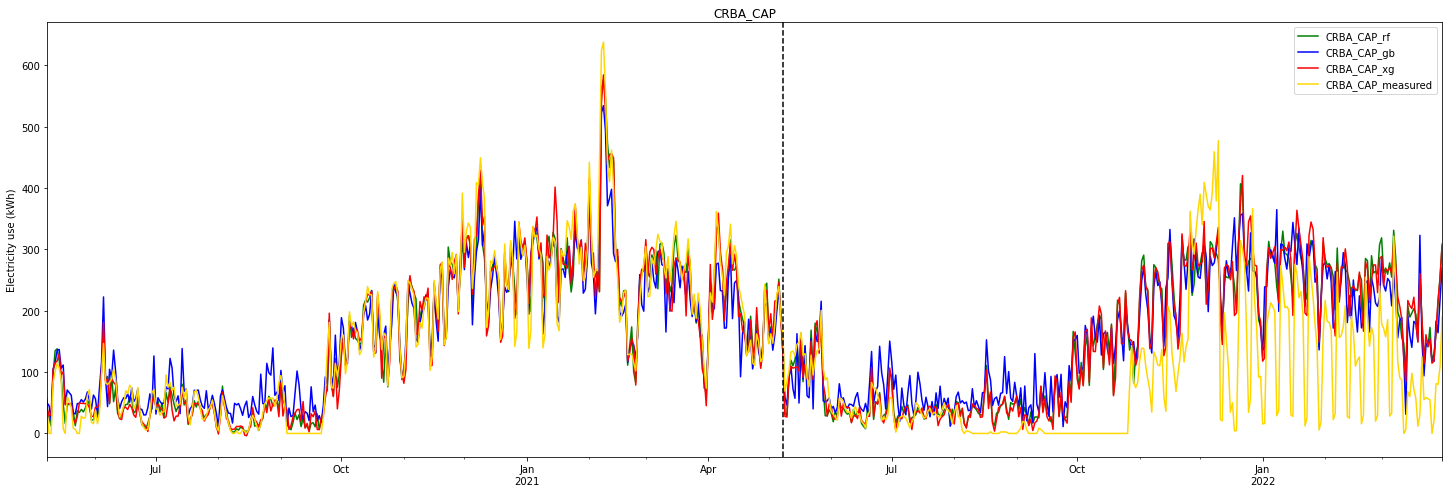

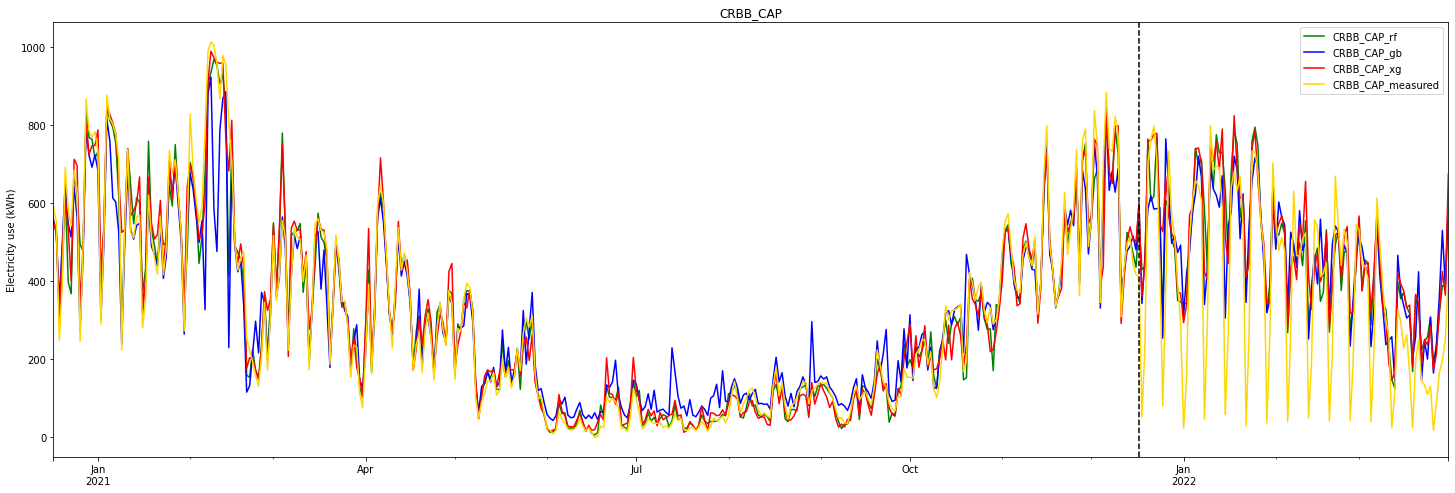

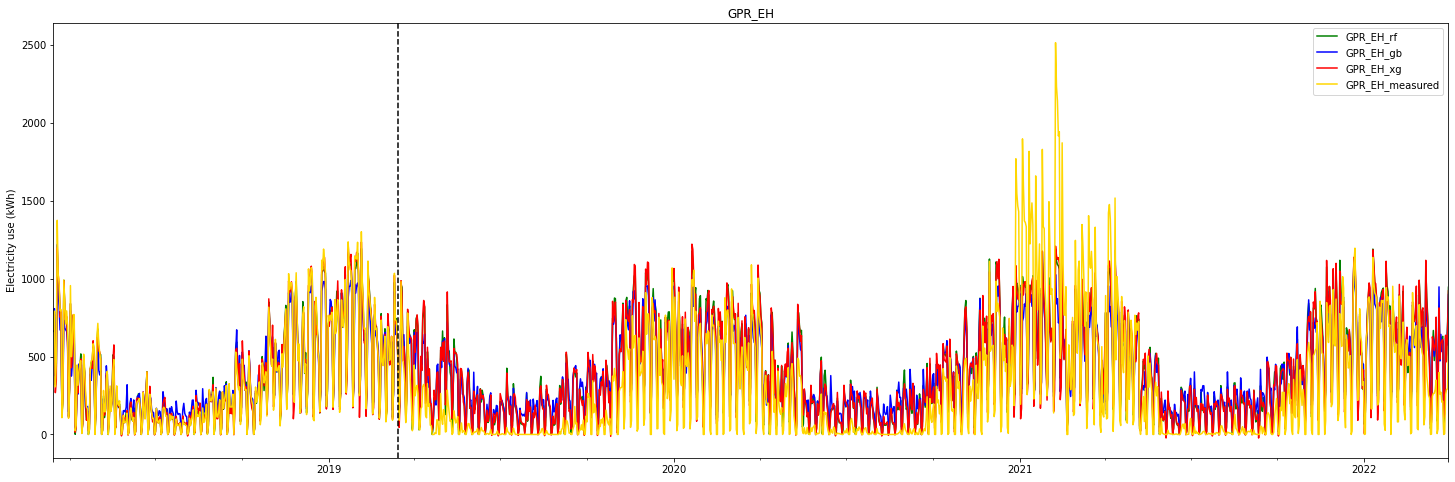

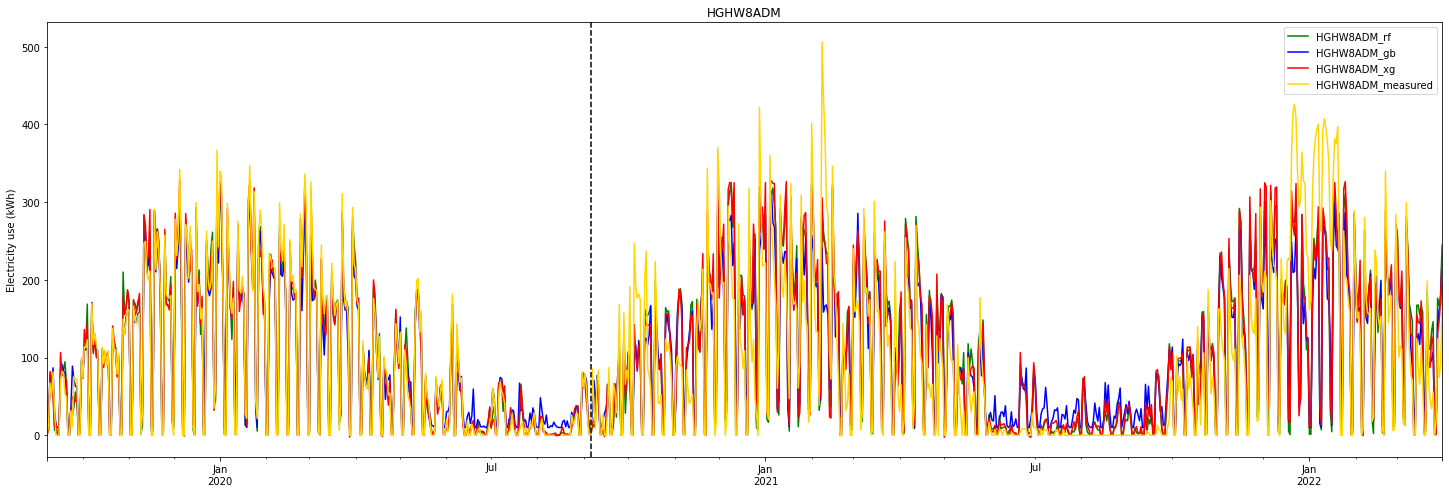

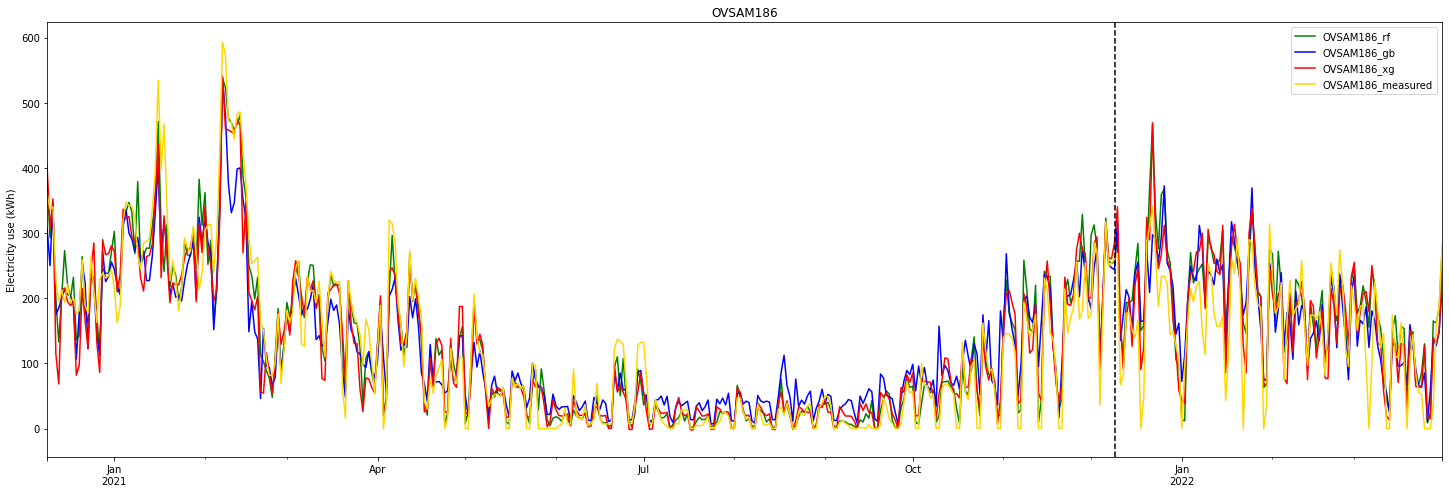

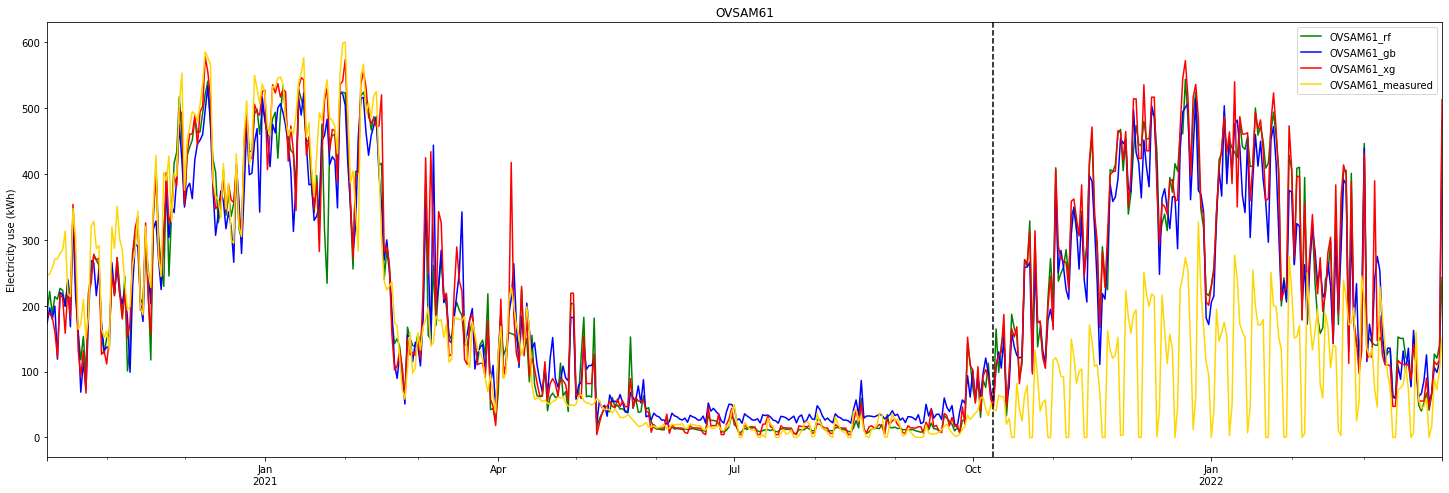

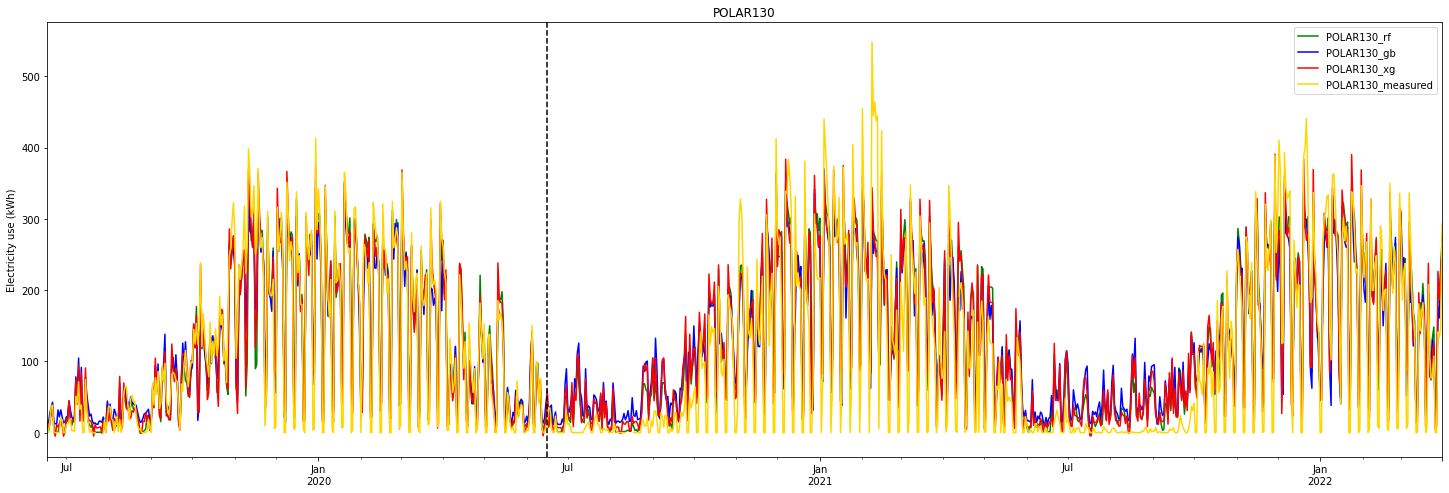

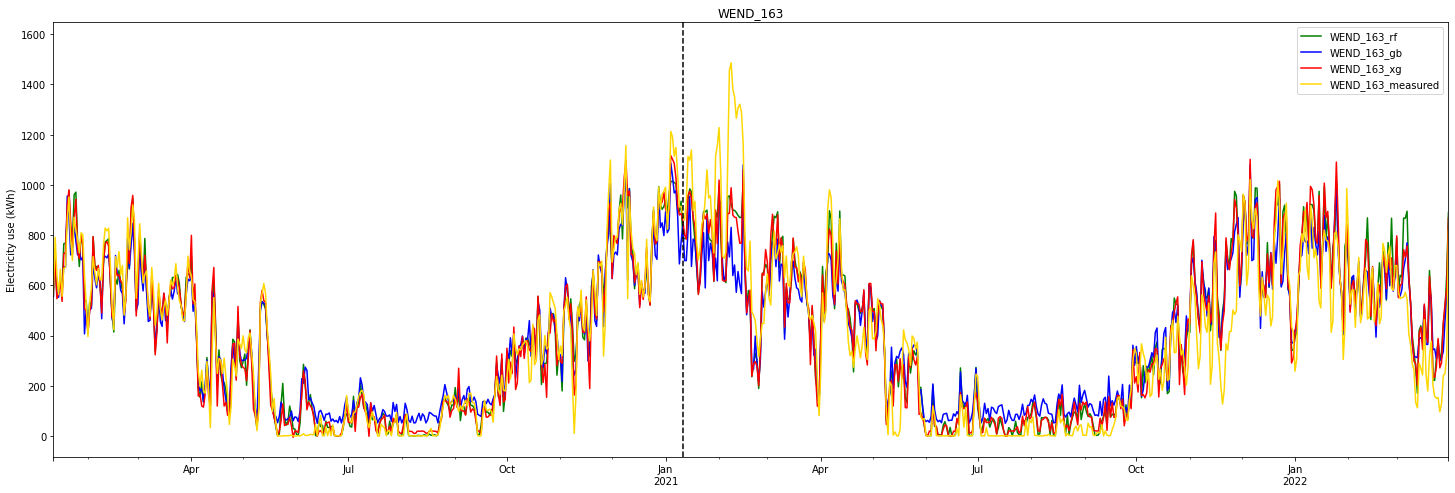

In [88]:
for building in gas_eans.index:
    t=pd.DataFrame()
    fig, ax = plt.subplots(figsize=(25, 8))
    gas_use_pred[building+"_rf"].plot(ax=ax, color='green')
    gas_use_pred[building+"_gb"].plot(ax=ax, color='blue')
    gas_use_pred[building+"_xg"].plot(ax=ax, color='red')
    t[building+"_measured"]=gas_use_meas[building+"_rf"]
    t.plot(ax=ax, color='gold')
    #electr_use_pred_en[building].plot(ax=ax, color='black')
    ax.set_xlim(left=gas_use_train[building].dropna().index[0])
    ax.set_title(building)
    ax.set_ylabel('Electricity use (kWh)')
    ax.legend()
    ax.axvline(x=socs[building], color='k', ls='--')
    plt.show(block=False)

### Comparison of individual models

In [132]:
gas_use_pred = pd.DataFrame(index=features.index)
for building in gas_eans.index:
    # select weather data for prediction
    city = cities[building]
    knmi_station = knmi_station_lookup[city]
    knmi_weather = weather[knmi_station]
    # preapare features for prediction
    features = pd.DataFrame()
    features['daily_mean_OAT'] = knmi_weather['T'].resample('d').mean()
    features['daily_sum_GHI'] = knmi_weather['Q'].resample('d').sum()
    features['dow'] = features.index.dayofweek
    #features['month'] = features.index.month
    X_pred = features
    # do the predictions
    models = os.listdir('MERIN_gas/data/trained_models/xg') #change for RF, GB, XG
    if fr'trained_{building}.joblib' in models:
        grid_search = joblib.load(fr'MERIN_gas/data/trained_models/xg/trained_{building}.joblib') #change for RF, GB, XG
    y_pred = grid_search.predict(X_pred)
    gas_use_pred[building] = y_pred

In [133]:
# compare predicted and measured gas use after start of control
engine = Engine(project=project, isAsync=False)
time_res = 'd'
gas_use_meas = pd.DataFrame(index=pd.date_range(start=train_periods['start'].min(),
                                                 end=knmi_weather.index[-1],
                                                 freq=time_res))
for building in gas_eans.index:
    # get gas use
    start = train_periods['start'].min()
    end = knmi_weather.index[-1]
    gas_ean = gas_eans[building]
    gas_use = engine.select(gas_ean).group_by(time_res).sum().after(start).before(end).all()
    gas_use = gas_use.rename(columns={gas_use.columns[0]:building})
    gas_use_meas = gas_use_meas.join(gas_use)

In [134]:
# calculate savings
# saving = (pred - meas)/pred
# storing in a dict, because each building has different number of months
month_savings = {}
month_savings_m3 = {}
total_savings_perc = pd.Series()
total_savings_m3 = pd.Series()
for building in gas_eans.index:
    #building = 'GPR_EH'
    start = train_periods.loc[building, 'start']
    end = knmi_weather.index[-1]
    soc = socs[building]
    # monthly savings (including the training preiod where savings should be ~0)
    gas_use_meas_m = gas_use_meas.loc[start:end, building].resample('m').sum()
    gas_use_pred_m = gas_use_pred.loc[start:end, building].resample('m').sum()
    month_saving = (gas_use_pred_m - gas_use_meas_m) / gas_use_pred_m * 100
    month_savings[building] = month_saving
    month_savings_m3[building] = gas_use_pred_m - gas_use_meas_m
    # total savings after SOC
    total_savings_m3[building] = (gas_use_pred.loc[soc:, building] - gas_use_meas.loc[soc:, building]).sum()
    total_savings_perc[building] = total_savings_m3[building] / gas_use_pred.loc[soc:, building].sum() * 100

# calculate prediction error for error bars
train_pred_mae = pd.Series()
for building in gas_eans.index:
    soc = socs[building]
    start = train_periods.loc[building, 'start']
    end = train_periods.loc[building, 'end'] #knmi_weather.index[-1]
    gas_use_meas_m = gas_use_meas.loc[start:end, building].resample('m').sum()
    gas_use_pred_m = gas_use_pred.loc[start:end, building].resample('m').sum()
    #soc_pos = calc_soc_pos_on_plot(df_compare_monthly=gas_use_meas_m, soc=soc)
    #gas_use_meas_m = gas_use_meas_m.iloc[:int(soc_pos)]
    #gas_use_pred_m = gas_use_pred_m.iloc[:int(soc_pos)]
    gas_use_month_mae = mean_absolute_error(y_true=gas_use_meas_m, y_pred=gas_use_pred_m)
    #train_pred_error = (gas_use_pred_m - gas_use_meas_m) / gas_use_pred_m * 100
    train_pred_mae[building] = gas_use_month_mae

In [135]:
total_savings_m3

CRBA_CAP     20631.206120
CRBB_CAP      9183.456617
GPR_EH      120724.255227
HGHW8ADM      5780.529318
OVSAM186      2556.319835
OVSAM61      32054.215572
POLAR130     13148.129225
WEND_163     11687.683084
dtype: float64

In [136]:
for building in gas_eans.index:
    total_savings_m3[building] = (gas_use_pred.loc[soc:, building] - gas_use_meas.loc[soc:, building]).sum()
    total_savings_perc[building] = ((gas_use_pred.loc[soc:, building] - gas_use_meas.loc[soc:, building]).sum() / gas_use_pred.loc[soc:, building].sum()) * 100
total_savings_perc

CRBA_CAP    25.294114
CRBB_CAP     6.579175
GPR_EH      12.239104
HGHW8ADM     8.626277
OVSAM186     4.467578
OVSAM61     41.794197
POLAR130    13.085990
WEND_163     6.005705
dtype: float64

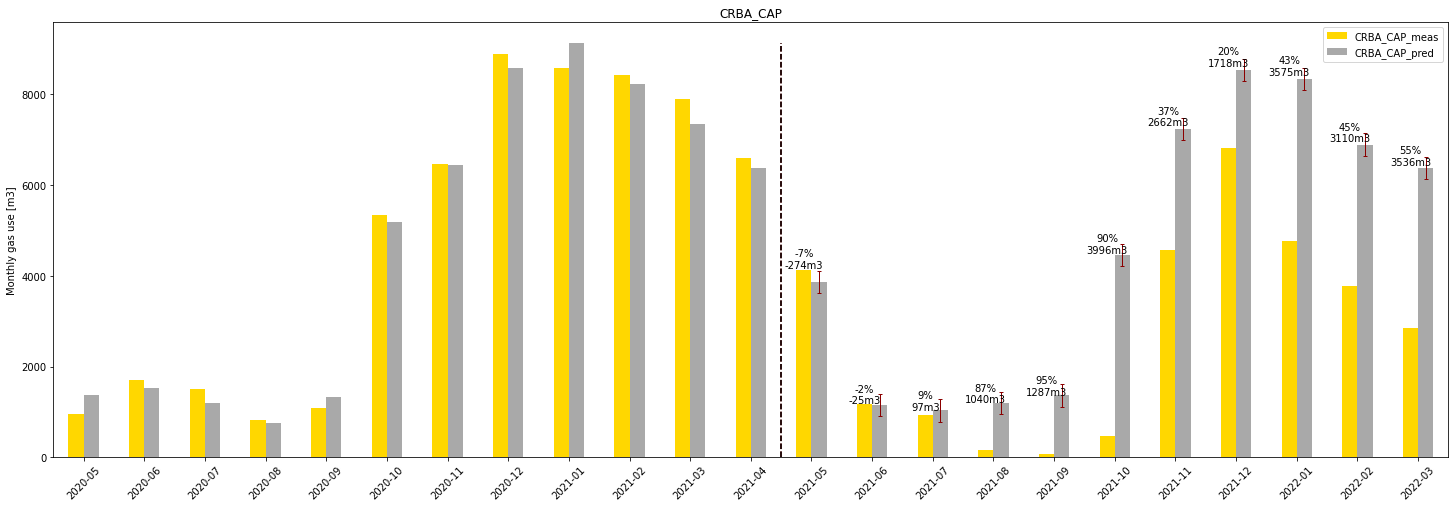

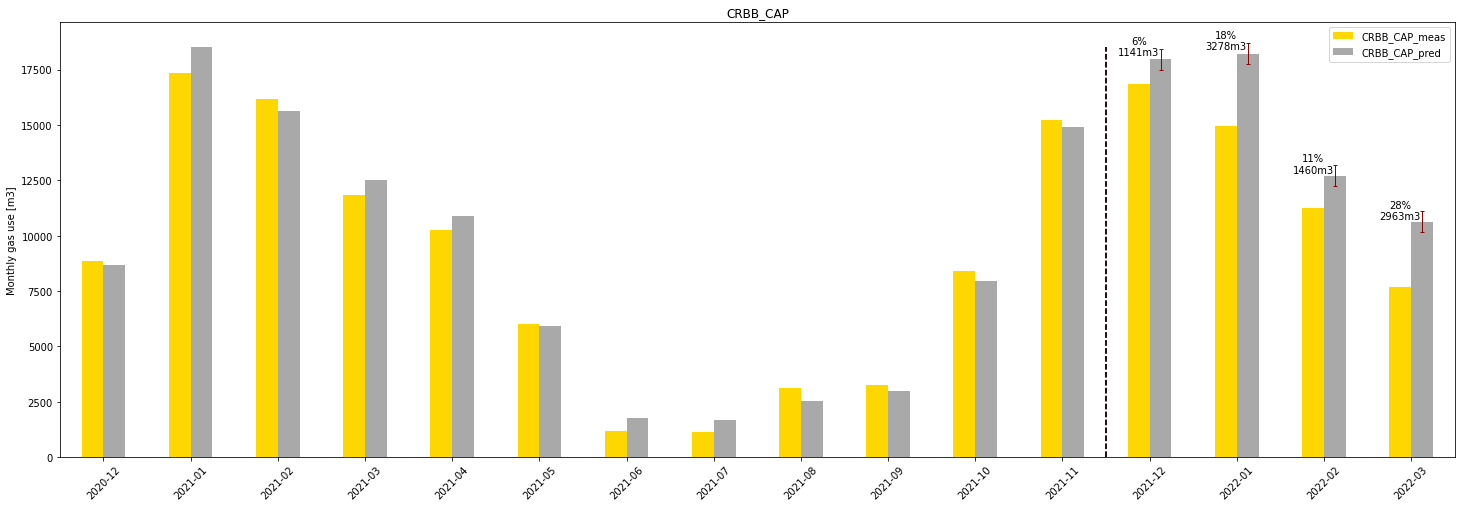

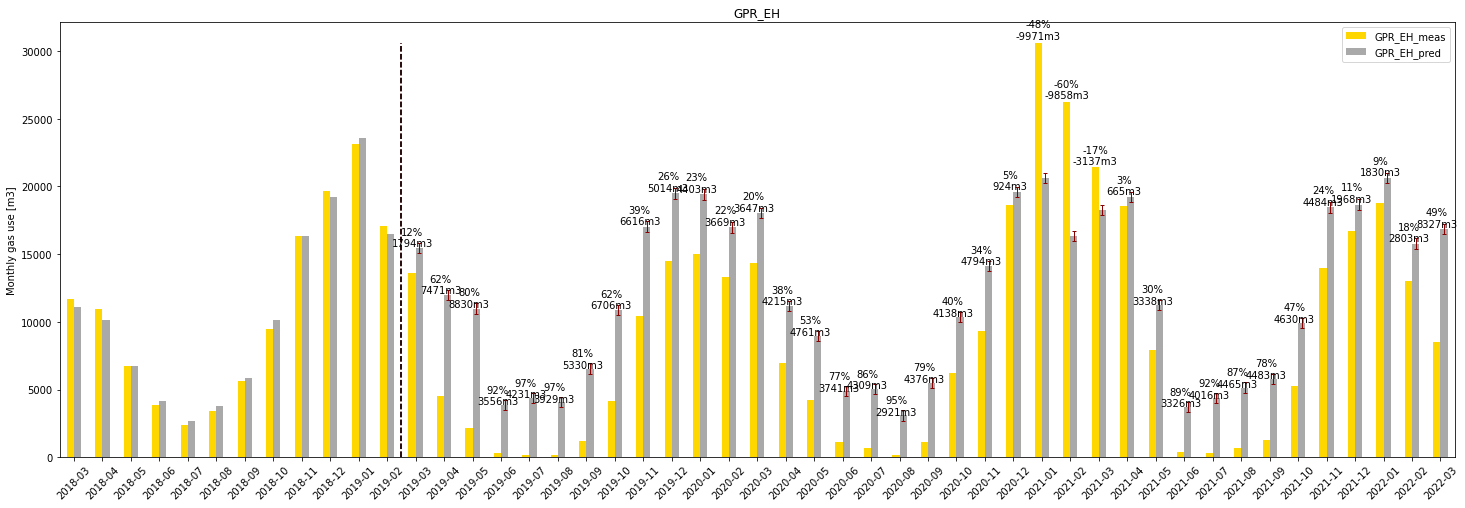

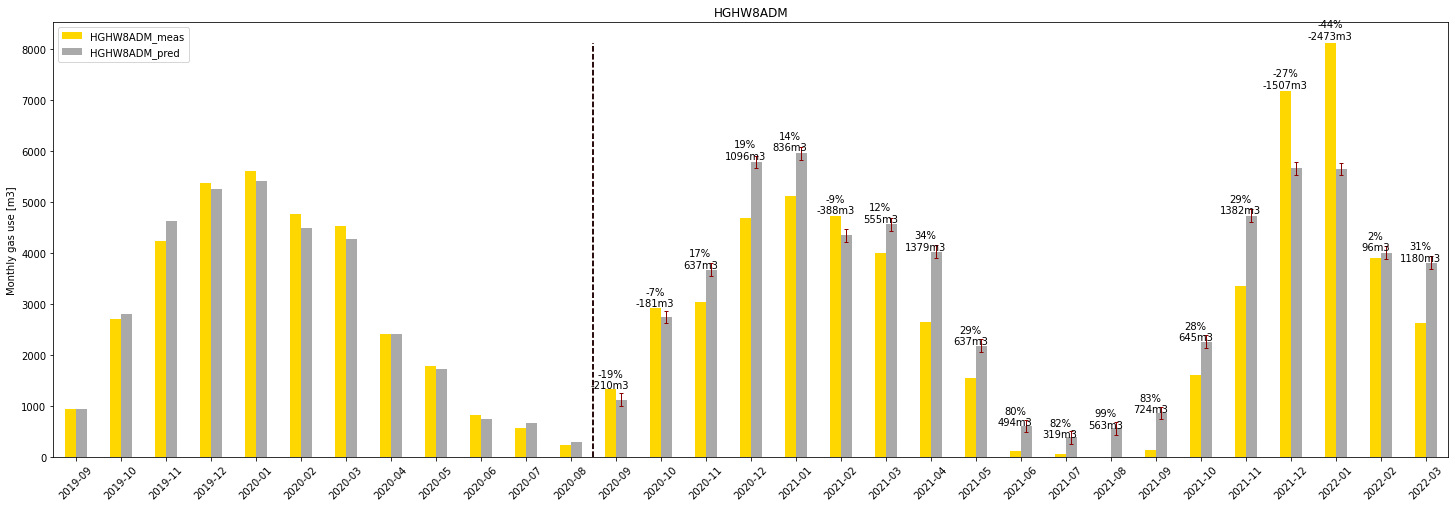

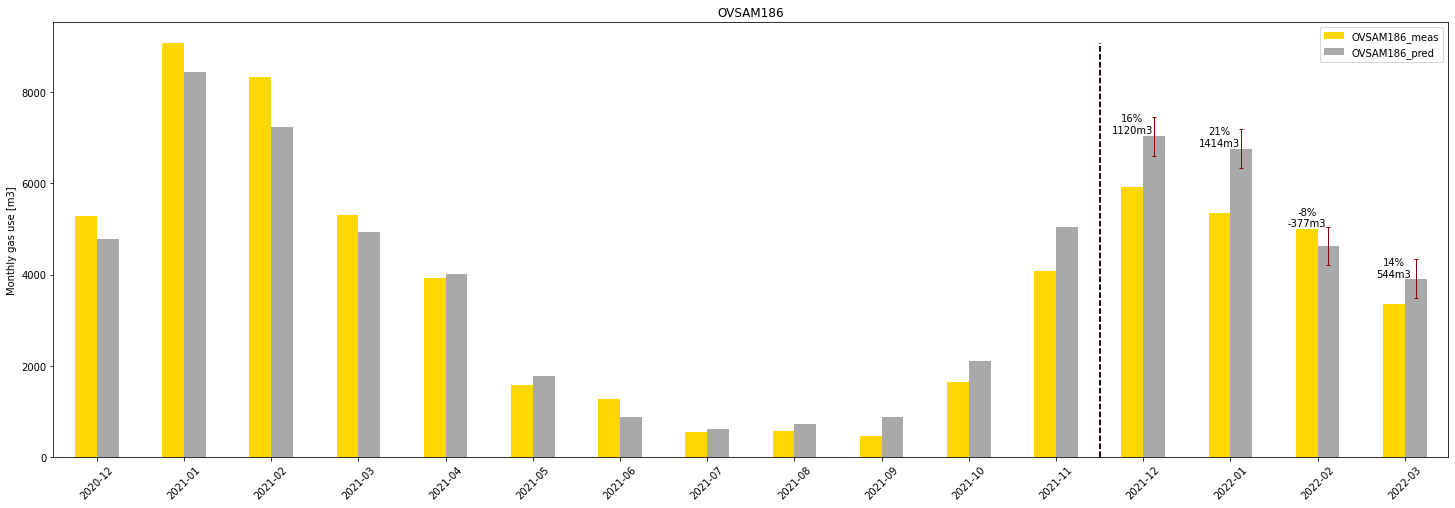

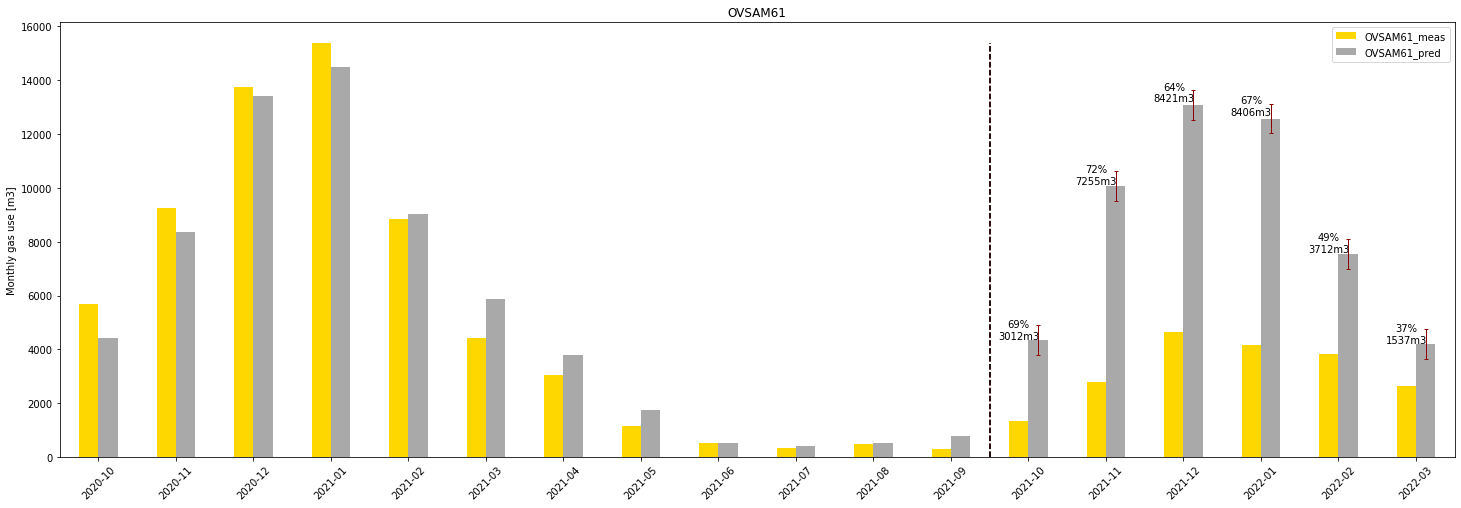

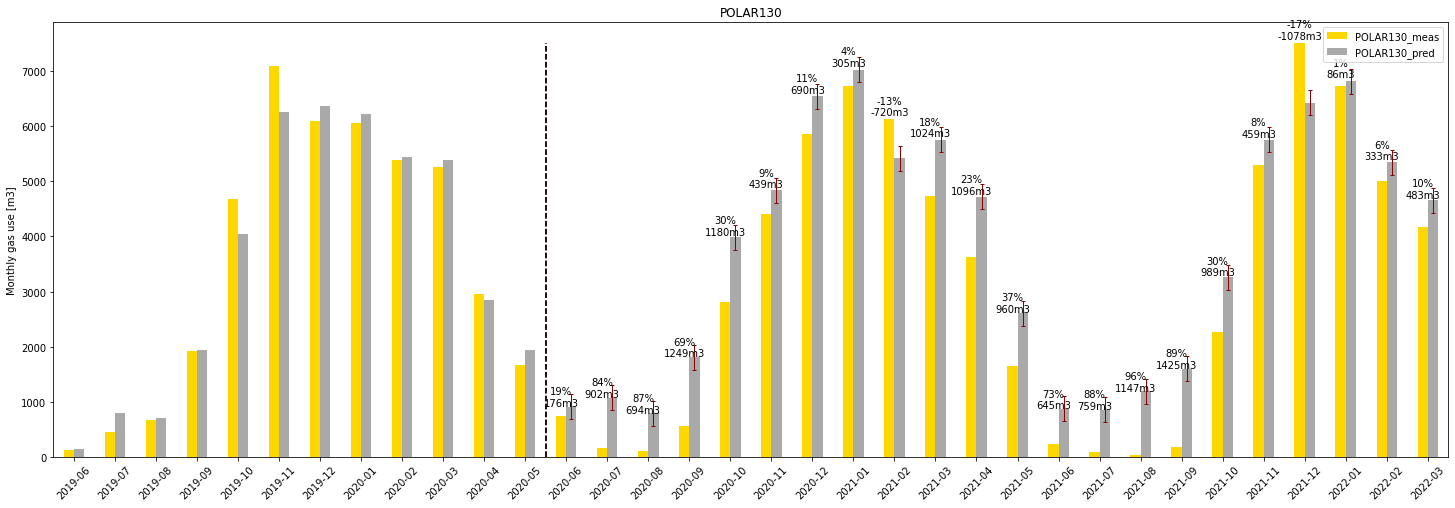

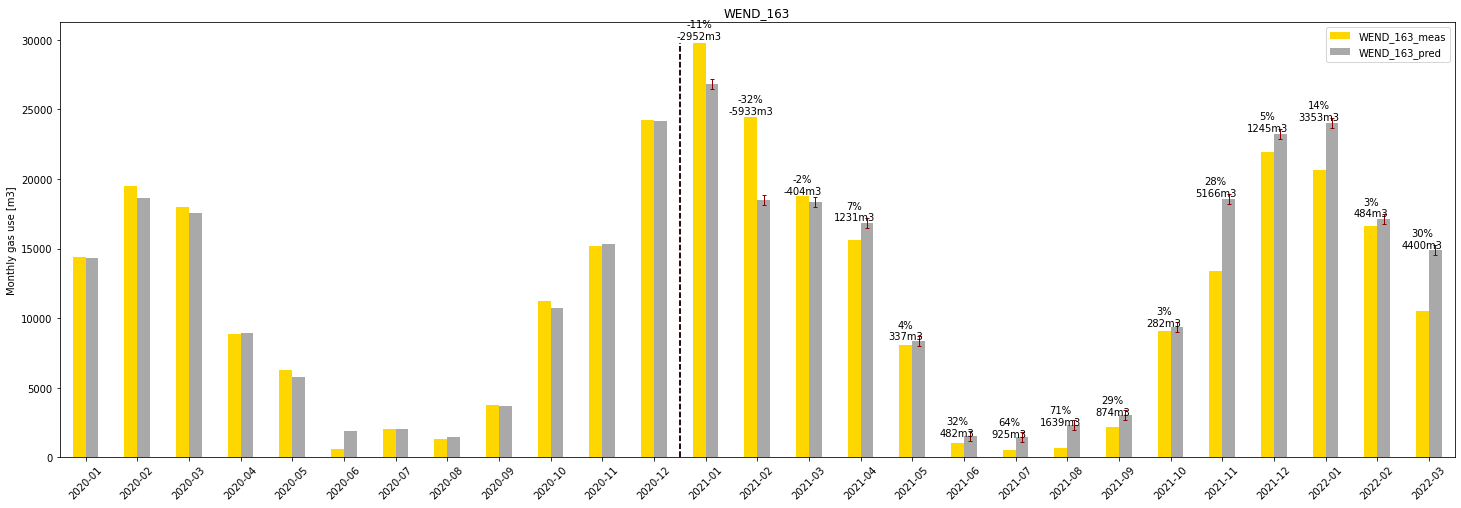

In [137]:
for building in gas_eans.index:
    start = train_periods.loc[building, 'start']
    end = knmi_weather.index[-1]
    df_compare = pd.DataFrame(index=pd.date_range(start=start,
                                                     end=end,
                                                     freq=time_res))
    df_compare = df_compare.join(gas_use_meas[[building]])
    df_compare = df_compare.rename(columns={building:fr'{building}_meas'})
    df_compare = df_compare.join(gas_use_pred[[building]])
    df_compare = df_compare.rename(columns={building:fr'{building}_pred'})
    #
    df_compare = df_compare.resample('m').sum()
    soc = socs[building]#.date()
    soc_pos = calc_soc_pos_on_plot(df_compare_monthly=df_compare, soc=soc)
    train_end_pos = calc_soc_pos_on_plot(df_compare_monthly=df_compare, soc=train_periods.loc[building, 'end'])
    #
    fig, ax = plt.subplots(figsize=(25, 8))
    err = pd.DataFrame(index=df_compare.index, data={fr'{building}_pred':train_pred_mae[building]})
    err.iloc[:int(soc_pos) + 1] = np.nan
    df_compare.plot.bar(ax=ax, color=['gold', 'darkgray'], yerr=err,
                        error_kw=dict(ecolor='darkred', lw=1, capsize=2, capthick=1))
    #soc_mark = pd.Series(index=df_compare.index, data=np.nan)
    ax.set_xticklabels([x.strftime("%Y-%m") for x in df_compare.index], rotation=45)
    plt.vlines(x=train_end_pos, ymin=0, ymax=df_compare.max().max(), color='darkred', ls='--')
    plt.vlines(x=soc_pos, ymin=0, ymax=df_compare.max().max(), color='k', ls='--')
    # adding saving % text
    patches = ax.patches
    patches_m = patches[0:int(len(patches)/2)]
    patches_p = patches[int(len(patches)/2):]
    for i, p in enumerate(patches[0:int(len(patches)/2)]):
        if i > soc_pos:
            saving = int(month_savings[building].iloc[i].round(0))
            saving_m3 = int(month_savings_m3[building].iloc[i].round(0))
            width = p.get_width()
            height = max(p.get_height(), patches_p[i].get_height())
            x, y = p.get_xy()
            ax.annotate(f'{saving}%\n{saving_m3}m3', (x + width/2, y + height*1.01), ha='center')
    #
    plt.ylabel('Monthly gas use [m3]')
    plt.title(building)
    plt.show(block=False)

In [143]:
# calculate monthly portfolio savings
gas_use_pred_sav = gas_use_pred
gas_use_meas_sav = gas_use_meas
for building in gas_eans.index:
    gas_use_pred_sav.loc[gas_use_pred_sav.index[0]:socs[building], building] = np.nan
    gas_use_meas_sav.loc[gas_use_meas_sav.index[0]:socs[building], building] = np.nan
gas_use_sav = gas_use_pred_sav - gas_use_meas_sav
gas_use_sav = gas_use_sav.resample('m').sum()
gas_use_sav = gas_use_sav.loc[socs[gas_eans.index].min():]

In [149]:
round(gas_use_sav.sum().sum(),2)

215564.23

In [150]:
round(gas_use_sav.sum().sum()*0.87, 2)

187540.88

In [148]:
for building in gas_use_sav.columns:
    print(building, "total savings since SOC (m3):", gas_use_sav[building].sum())

CRBA_CAP total savings since SOC (m3): 20662.36171388626
CRBB_CAP total savings since SOC (m3): 8997.526472091675
GPR_EH total savings since SOC (m3): 120735.543159917
HGHW8ADM total savings since SOC (m3): 5778.667629152536
OVSAM186 total savings since SOC (m3): 2530.6401472091675
OVSAM61 total savings since SOC (m3): 32048.0945892334
POLAR130 total savings since SOC (m3): 13101.420723341405
WEND_163 total savings since SOC (m3): 11709.978433609009


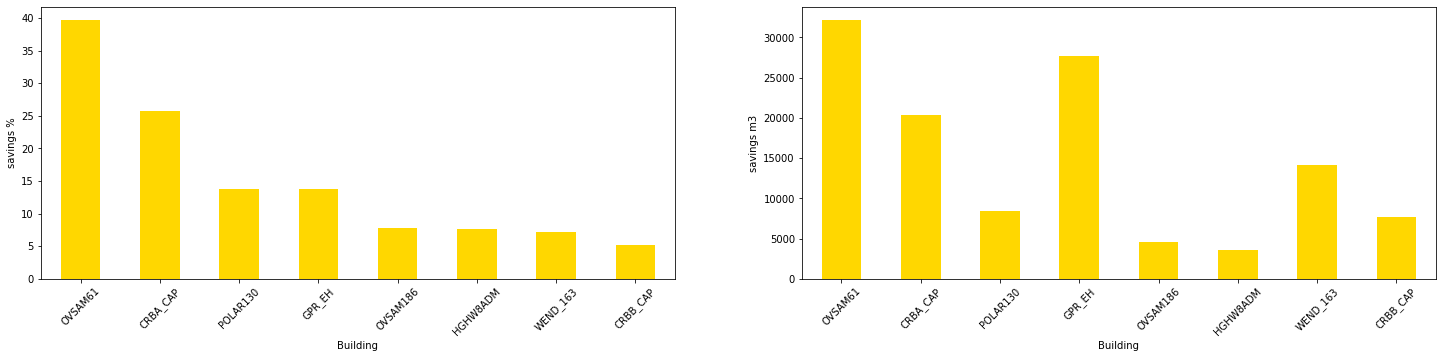

In [127]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(25, 5))
for col, ax in zip(sorted(total_savings_plot_df.columns), axs.ravel()):
    total_savings_plot_df[col].plot.bar(ax=ax, color=['gold'])
    ax.set_xticklabels([x for x in total_savings_plot_df.index], rotation=45)
    ax.set_xlabel('Building')
    ax.set_ylabel(col)
plt.show(block=False)

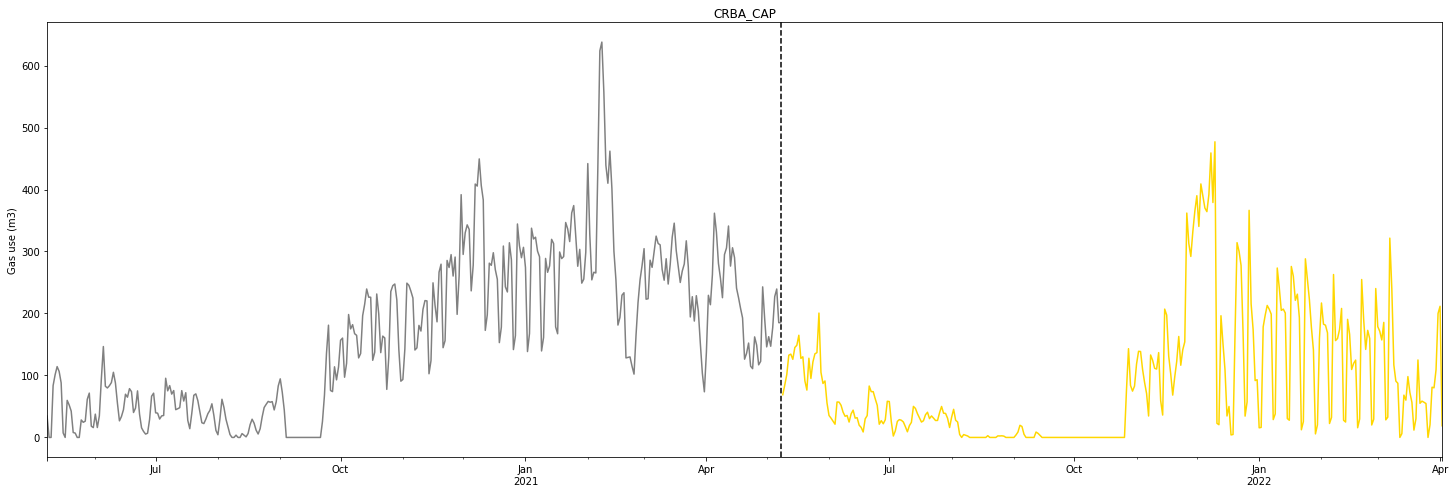

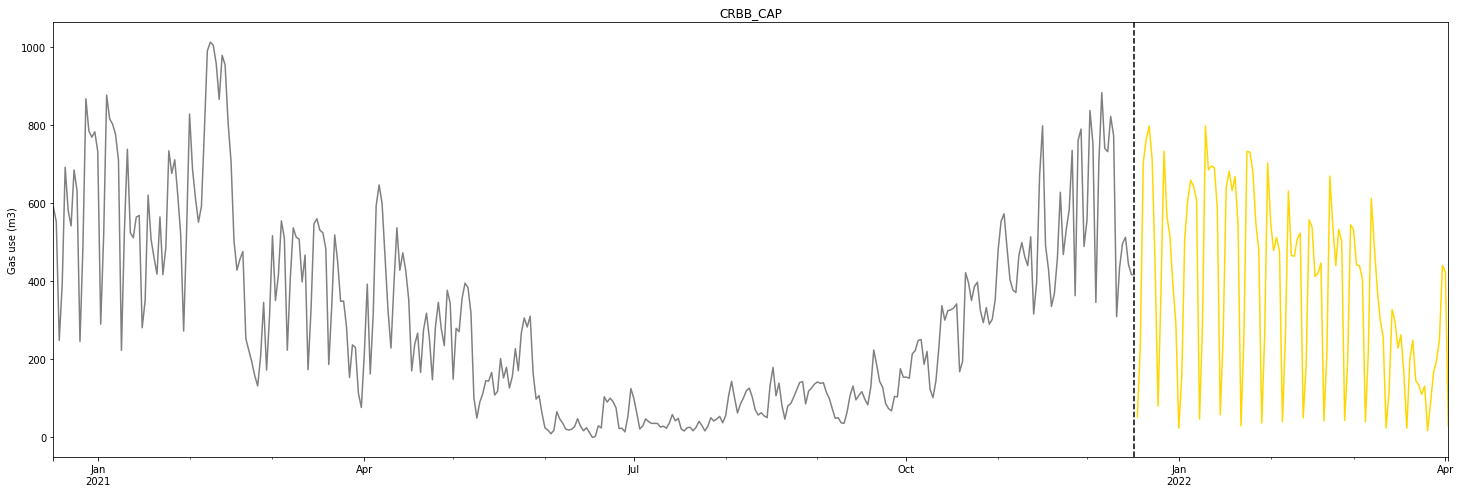

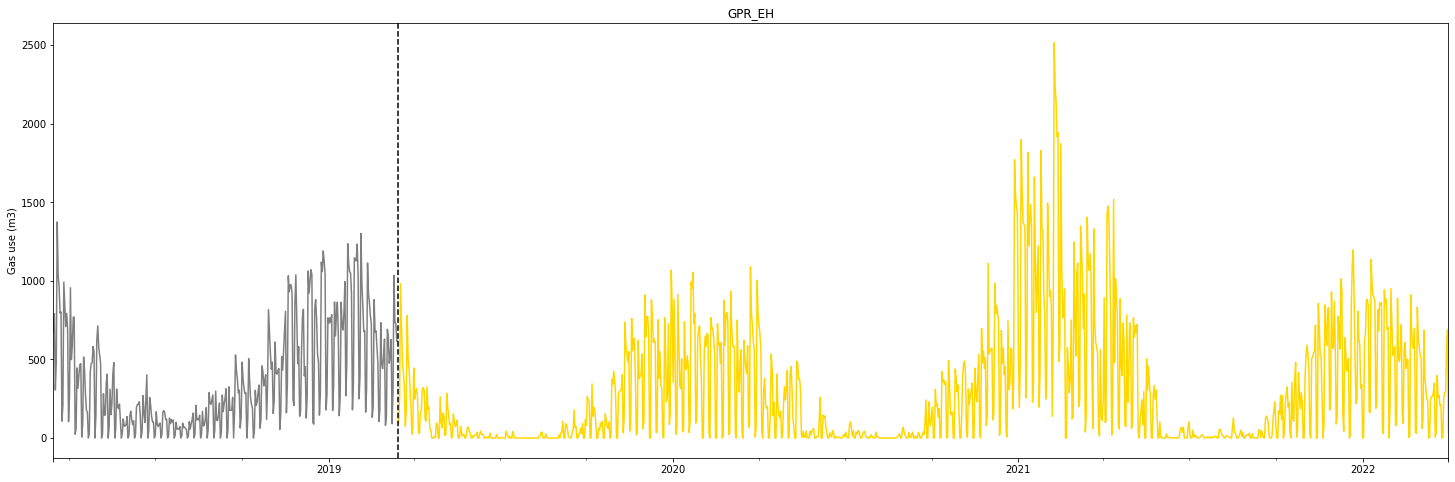

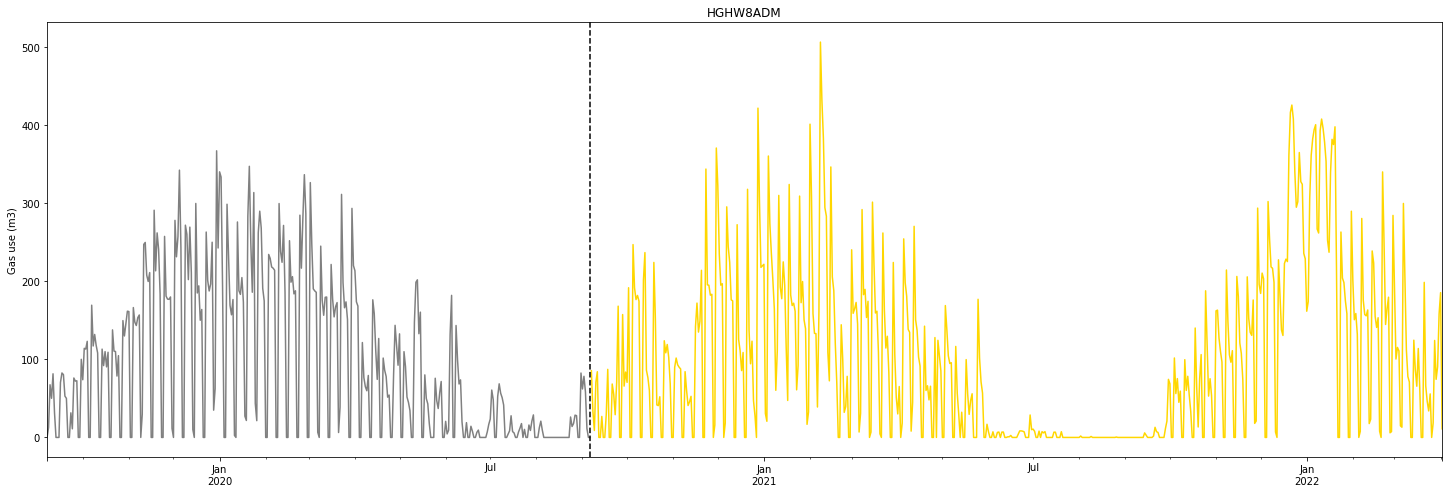

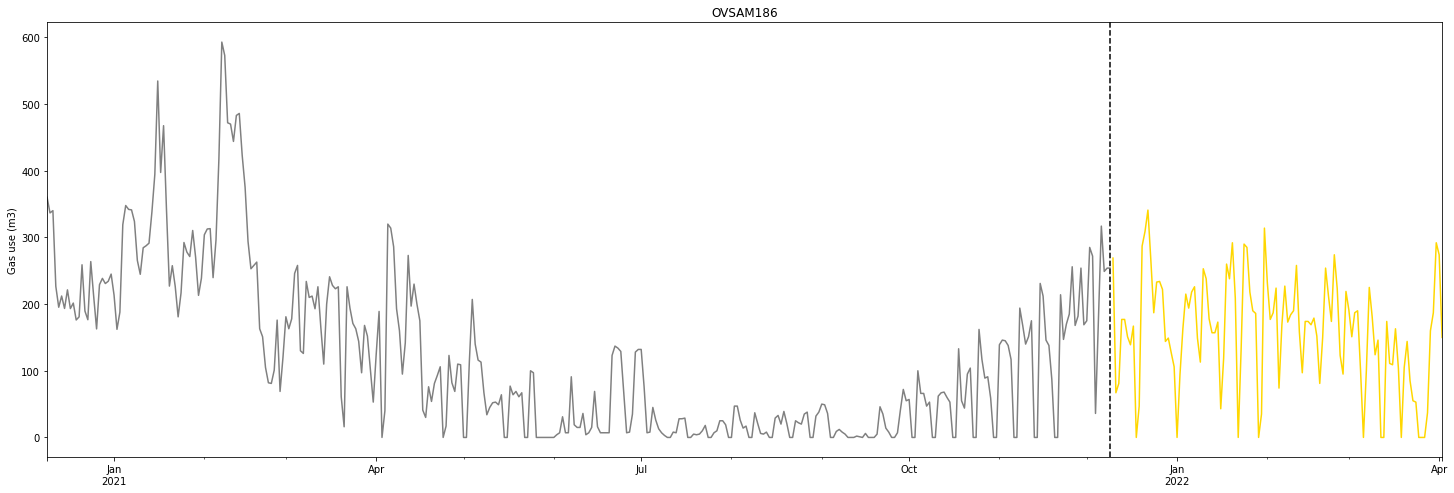

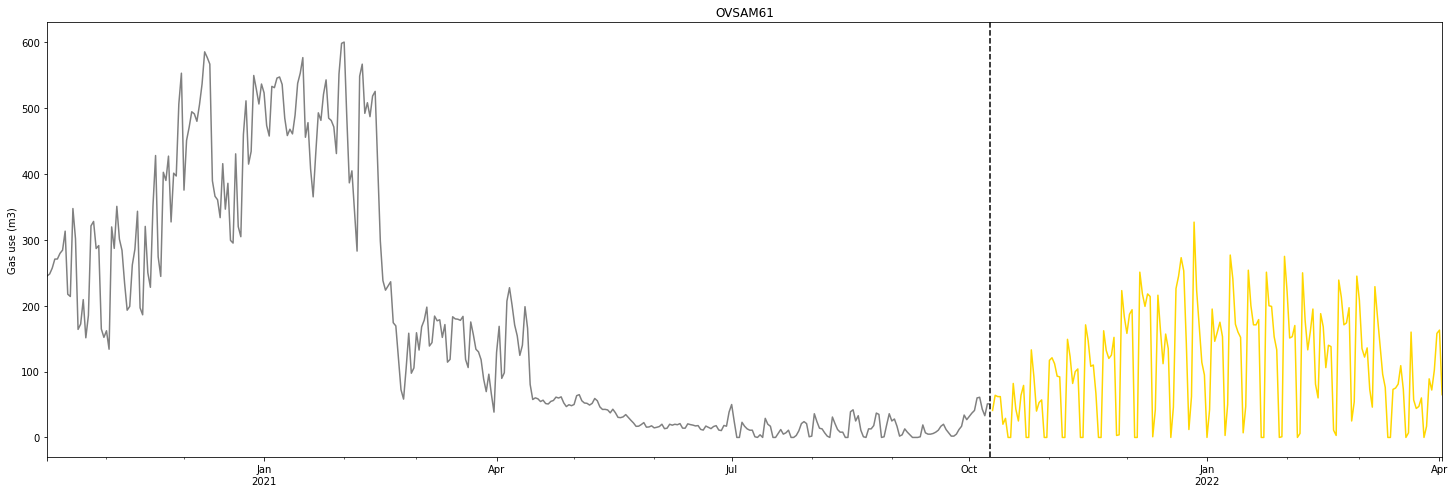

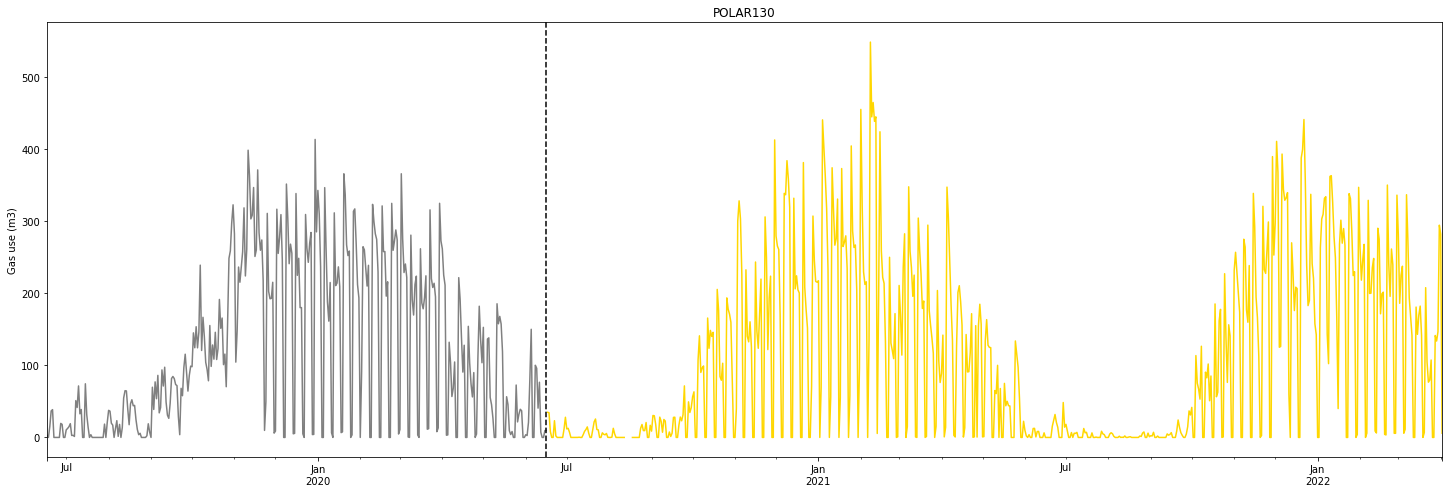

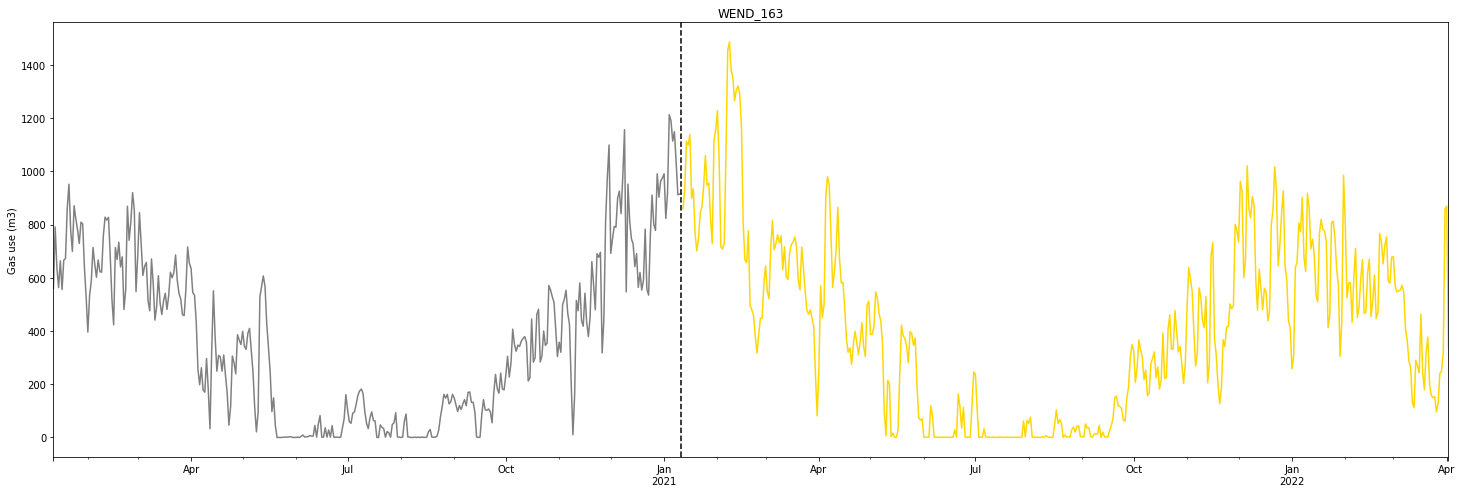

In [167]:
for building in gas_eans.index:
    fig, ax = plt.subplots(figsize=(25, 8))
    gas_use_train[building].plot(ax=ax, color='gray')
    gas_use_meas[building].plot(ax=ax, color='gold')
    ax.set_xlim(left=gas_use_train[building].dropna().index[0])
    ax.set_title(building)
    ax.set_ylabel('Gas use (m3)')
    ax.axvline(x=socs[building], color='k', ls='--')
    plt.show(block=False)

### Monthly

In [157]:
gas_use_pred_sav = gas_use_pred
gas_use_meas_sav = gas_use_meas
for building in gas_eans.index:
    gas_use_pred_sav.loc[gas_use_pred_sav.index[0]:socs[building], building] = np.nan
    gas_use_meas_sav.loc[gas_use_meas_sav.index[0]:socs[building], building] = np.nan
gas_use_sav = gas_use_pred_sav - gas_use_meas_sav
gas_use_sav = gas_use_sav.resample('m').sum()
gas_use_sav = gas_use_sav.loc[socs[gas_eans.index].min():]
gas_use_sav['m3_cost']=0.87 #assuming cost of m3 is 0.76 cents, could be changed
for col in gas_use_sav.columns:
    gas_use_sav[col]=round(gas_use_sav['m3_cost']*gas_use_sav[col],2)
del gas_use_sav['m3_cost']

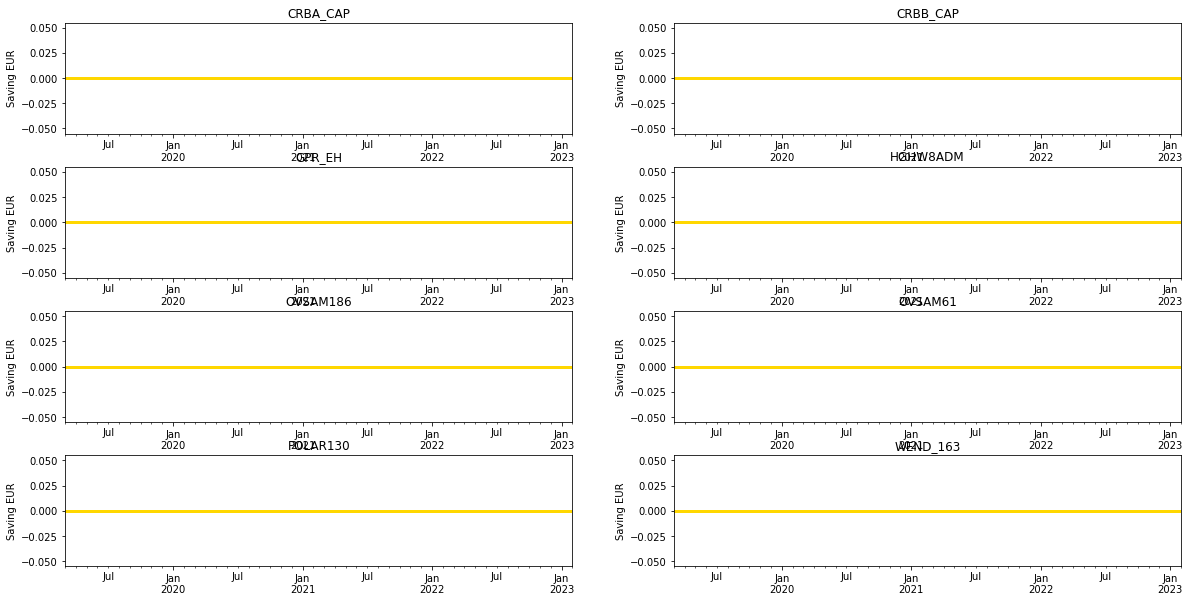

In [158]:
fig, axs = plt.subplots(nrows=4, ncols=2, figsize=(20, 10))
plt.subplots_adjust(hspace=0.3)
for col, ax in zip(sorted(gas_use_sav.columns), axs.ravel()):
    index=gas_use_sav[col].index.get_loc(gas_use_sav[col].ne(0).idxmax())
    gas_use_sav[[col]].iloc[index:-1].plot(ax=ax, color='gold', linewidth=3) #excludes April for now, too early in the month to draw results
    ax.set_title(col.upper())
    ax.get_legend().remove()
    ax.set_ylabel("Saving EUR")

# Forecasting

In [101]:
#forecast periods are defined, which is - per building - SOC up until 31st of March 2022
forecast_periods=pd.DataFrame()
forecast_periods['start'] = socs[gas_eans.index]
forecast_periods['end'] = pd.Timestamp('2022-03-31')
forecast_periods=forecast_periods[~forecast_periods.index.duplicated(keep='first')]
forecast_periods

,start,end
keyname_01,,
CRBA_CAP,2021-05-08,2022-03-31
CRBB_CAP,2021-12-17,2022-03-31
GPR_EH,2019-03-15,2022-03-31
HGHW8ADM,2020-09-06,2022-03-31
OVSAM186,2021-12-09,2022-03-31
OVSAM61,2021-10-09,2022-03-31
POLAR130,2020-06-16,2022-03-31
WEND_163,2021-01-11,2022-03-31


In [102]:
engine = Engine(project=project, isAsync=False)
time_res = 'd'
gas_use_train = pd.DataFrame(index=pd.date_range(start=forecast_periods['start'].min(),
                                                 end=forecast_periods['end'].max(),
                                                 freq=time_res))

# data from sp-ql
for building in gas_eans.index:
    # get gas use
    start_train = forecast_periods.loc[building, 'start']
    end_train = forecast_periods.loc[building, 'end']
    gas_ean = gas_eans[building]
    gas_use = engine.select(gas_ean).group_by(time_res).sum().after(start_train).before(end_train).all()
    gas_use = gas_use.rename(columns={gas_use.columns[0]:building})
    gas_use_train = gas_use_train.join(gas_use)
gas_use_train.to_csv(r'MERIN_gas/data/gas_use_train_f.csv')

In [103]:
gas_use_train = pd.read_csv(r'MERIN_gas/data/gas_use_train_f.csv', index_col=0,
                            parse_dates=True)
# some buildings have small gaps in gas data. We can interpolate over these
for building in gas_eans.index:
    start_train = forecast_periods.loc[building, 'start']
    end_train = forecast_periods.loc[building, 'end']
    gas_use_train_build = gas_use_train.loc[start_train:end_train, building]
    # setting first element to 0 if nan. To aid interpolation.
    if gas_use_train_build.iloc[[0]].isna()[0]:
        gas_use_train_build.iloc[0] = 0
    gas_use_train_build = gas_use_train_build.interpolate(limit=10) # filling max 10 consecutive days of missing data
    gas_use_train.loc[start_train:end_train, building] = gas_use_train_build

### Random Forest

In [109]:
for building in gas_eans.index:
    print(fr'Training building {building}, {gas_eans.index.get_loc(building) + 1}/{len(gas_eans)}')
    city = cities[building]
    knmi_station = knmi_station_lookup[city]
    knmi_weather = weather[knmi_station]
    start_train = forecast_periods.loc[building, 'start']
    end_train = forecast_periods.loc[building, 'end']

    if knmi_station==240:
        features = pd.read_csv('features_240.csv', index_col=0, squeeze=True)
    if knmi_station==344:
        features = pd.read_csv('features_344.csv', index_col=0, squeeze=True)
    if knmi_station==370:
        features = pd.read_csv('features_370.csv', index_col=0, squeeze=True)
    if knmi_station==260:
        features = pd.read_csv('features_260.csv', index_col=0, squeeze=True)
    if knmi_station==275:
        features = pd.read_csv('features_275.csv', index_col=0, squeeze=True)
        
    del features['SQ'] #is only used for electricity
    
    features.index = pd.date_range('2011-01-01', periods=4473, freq='1D')
    features['dow'] = features.index.dayofweek
    gas_use_train_build = gas_use_train[building]
    
    # X: training features, y: training target
    X = features[(features.index >= start_train) & (features.index < end_train)]
    y = gas_use_train_build[(gas_use_train_build.index >= start_train) &
                            (gas_use_train_build.index < end_train)]
    #
    # checking if there is any nan in the data
    if X.isna().sum().sum() + y.isna().sum() > 0:
        raise ValueError('NaN in training data:', building)
    #
    # checking on dependency of taget on features to get a feel
    if False:
        fig, ax = plt.subplots(len(X.columns), 1)
        for i, c in enumerate(X.columns):
            ax[i].scatter(x=X[c], y=y)
            ax[i].set_title(c)
        plt.show(block=False)
    #
    # make train-test split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)
    #
    # grid-search for hyper parameter tuning
    param_grid = {'max_depth': [2, 5, 10, 20, 50, 100],
                  'min_samples_leaf': [1, 5, 10],
                  'n_estimators': [500]}
    rf = RandomForestRegressor()
    grid_search = GridSearchCV(estimator=rf, param_grid=param_grid,
                               cv=KFold(10, shuffle=True), n_jobs=-1, verbose=False)
    grid_search.fit(X_train, y_train)
    #
    # save the trained RF
    joblib.dump(grid_search.best_estimator_, fr'MERIN_gas/data/trained_models/f_rf/trained_{building}.joblib')
    joblib.dump(X_test, fr'MERIN_gas/data/trained_models/f_rf/X_test_{building}.joblib')
    joblib.dump(y_test, fr'MERIN_gas/data/trained_models/f_rf/y_test_{building}.joblib')

Training building CRBA_CAP, 1/8
Training building CRBB_CAP, 2/8
Training building GPR_EH, 3/8
Training building HGHW8ADM, 4/8
Training building OVSAM186, 5/8
Training building OVSAM61, 6/8
Training building POLAR130, 7/8
Training building WEND_163, 8/8


### Gradient Boosting

In [104]:
warnings.filterwarnings("ignore")

for building in gas_eans.index:
    print(fr'Training building {building}, {gas_eans.index.get_loc(building) + 1}/{len(gas_eans.index)}')
    city = cities[building]
    knmi_station = knmi_station_lookup[city]
    knmi_weather = weather[knmi_station]
    start_train = forecast_periods.loc[building, 'start']
    end_train = forecast_periods.loc[building, 'end']

    if knmi_station==240:
        features = pd.read_csv('features_240.csv', index_col=0, squeeze=True)
    if knmi_station==344:
        features = pd.read_csv('features_344.csv', index_col=0, squeeze=True)
    if knmi_station==370:
        features = pd.read_csv('features_370.csv', index_col=0, squeeze=True)
    if knmi_station==260:
        features = pd.read_csv('features_260.csv', index_col=0, squeeze=True)
    if knmi_station==275:
        features = pd.read_csv('features_275.csv', index_col=0, squeeze=True)
        
    del features['SQ'] #is only used for electricity
    
    features.index = pd.date_range('2011-01-01', periods=4473, freq='1D')
    features['dow'] = features.index.dayofweek
    gas_use_train_build = gas_use_train[building]
    
    X = features[(features.index >= start_train) & (features.index < end_train)]
    y = gas_use_train_build[(gas_use_train_build.index >= start_train) &
                            (gas_use_train_build.index < end_train)]


    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

    param_grid = {
    "learning_rate": [0.01, 0.025, 0.05, 0.075, 0.1, 0.15, 0.2],
    "max_depth":[3,5,8],
    "max_features":["log2","sqrt"],
    "subsample":[0.5, 0.618, 0.8, 0.85, 0.9, 0.95, 1.0],
    "n_estimators":[10],
    }

    rf = GradientBoostingRegressor()

    grid_search = GridSearchCV(estimator=rf, param_grid=param_grid,
                        cv=KFold(10, shuffle=True), n_jobs=-1, verbose=False)
    grid_search.fit(X_train, y_train)

    joblib.dump(grid_search.best_estimator_, fr'MERIN_gas/data/trained_models/f_gb/trained_{building}.joblib')
    joblib.dump(X_test, fr'MERIN_gas/data/trained_models/f_gb/X_test_{building}.joblib')
    joblib.dump(y_test, fr'MERIN_gas/data/trained_models/f_gb/y_test_{building}.joblib')

Training building CRBA_CAP, 1/8
Training building CRBB_CAP, 2/8
Training building GPR_EH, 3/8
Training building HGHW8ADM, 4/8
Training building OVSAM186, 5/8
Training building OVSAM61, 6/8
Training building POLAR130, 7/8
Training building WEND_163, 8/8


### XGBoosting

In [110]:
for building in gas_eans.index:
    print(fr'Training building {building}, {gas_eans.index.get_loc(building) + 1}/{len(gas_eans)}')
    city = cities[building]
    knmi_station = knmi_station_lookup[city]
    knmi_weather = weather[knmi_station]
    start_train = forecast_periods.loc[building, 'start']
    end_train = forecast_periods.loc[building, 'end']

    if knmi_station==240:
        features = pd.read_csv('features_240.csv', index_col=0, squeeze=True)
    if knmi_station==344:
        features = pd.read_csv('features_344.csv', index_col=0, squeeze=True)
    if knmi_station==370:
        features = pd.read_csv('features_370.csv', index_col=0, squeeze=True)
    if knmi_station==260:
        features = pd.read_csv('features_260.csv', index_col=0, squeeze=True)
    if knmi_station==275:
        features = pd.read_csv('features_275.csv', index_col=0, squeeze=True)
        
    del features['SQ'] #is only used for electricity
    
    features.index = pd.date_range('2011-01-01', periods=4473, freq='1D')
    features['dow'] = features.index.dayofweek
    gas_use_train_build = gas_use_train[building]
    
    X = features[(features.index >= start_train) & (features.index < end_train)]
    y = gas_use_train_build[(gas_use_train_build.index >= start_train) &
                            (gas_use_train_build.index < end_train)]
    if X.isna().mean().mean() + y.isna().mean() > 0:
        raise ValueError('NaN in training data:', building)
    if False:
        fig, ax = plt.subplots(len(X.columns), 1)
        for i, c in enumerate(X.columns):
            ax[i].scatter(x=X[c], y=y)
            ax[i].set_title(c)
        plt.show(block=False)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)
    
    
    param_grid={
                "learning_rate": (0.05, 0.10, 0.15, 0.2),
                "max_depth": [3, 4, 5, 6, 8],
                "min_child_weight": [1, 3, 5, 7]
                }

    rf = XGBRegressor()
    cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
    grid_search = GridSearchCV(estimator=rf, param_grid=param_grid,
                               cv=cv, n_jobs=-1, verbose=False)
    grid_search.fit(X_train, y_train)

    joblib.dump(grid_search.best_estimator_, fr'MERIN_gas/data/trained_models/f_xg/trained_{building}.joblib')
    joblib.dump(X_test, fr'MERIN_gas/data/trained_models/f_xg/X_test_{building}.joblib')
    joblib.dump(y_test, fr'MERIN_gas/data/trained_models/f_xg/y_test_{building}.joblib')

Training building CRBA_CAP, 1/8
Training building CRBB_CAP, 2/8
Training building GPR_EH, 3/8
Training building HGHW8ADM, 4/8
Training building OVSAM186, 5/8
Training building OVSAM61, 6/8
Training building POLAR130, 7/8
Training building WEND_163, 8/8


### Predictions

In [111]:
gas_use_pred = pd.DataFrame(index=features.index)
for m in ['rf','gb','xg']:
    for building in gas_eans.index:
        
        city = cities[building]
        knmi_station = knmi_station_lookup[city]
        knmi_weather = weather[knmi_station]
        
        if knmi_station==240:
            features = pd.read_csv('features_240.csv', index_col=0, squeeze=True)
        if knmi_station==344:
            features = pd.read_csv('features_344.csv', index_col=0, squeeze=True)
        if knmi_station==370:
            features = pd.read_csv('features_370.csv', index_col=0, squeeze=True)
        if knmi_station==260:
            features = pd.read_csv('features_260.csv', index_col=0, squeeze=True)
        if knmi_station==275:
            features = pd.read_csv('features_275.csv', index_col=0, squeeze=True)

        features.index = pd.date_range('2011-01-01', periods=4473, freq='1D')
        del features['SQ'] #is only used for electricity
        features['dow'] = features.index.dayofweek
        #features['month'] = features.index.month
        X_pred = features
        # do the predictions
        models = os.listdir(f'MERIN_gas/data/trained_models/f_{m}')
        if fr'trained_{building}.joblib' in models:
            grid_search = joblib.load(fr'MERIN_gas/data/trained_models/f_{m}/trained_{building}.joblib')
        y_pred = grid_search.predict(X_pred)
        gas_use_pred[building+'_'+m] = y_pred

In [112]:
#ensemble stacking, equal weight
gas_use_pred['CRBA_CAP_en']=(gas_use_pred['CRBA_CAP_rf']+gas_use_pred['CRBA_CAP_gb']+gas_use_pred['CRBA_CAP_xg'])/3
gas_use_pred['CRBB_CAP_en']=(gas_use_pred['CRBB_CAP_rf']+gas_use_pred['CRBB_CAP_gb']+gas_use_pred['CRBB_CAP_xg'])/3
gas_use_pred['GPR_EH_en']=(gas_use_pred['GPR_EH_rf']+gas_use_pred['GPR_EH_gb']+gas_use_pred['GPR_EH_xg'])/3
gas_use_pred['HGHW8ADM_en']=(gas_use_pred['HGHW8ADM_rf']+gas_use_pred['HGHW8ADM_gb']+gas_use_pred['HGHW8ADM_xg'])/3
gas_use_pred['OVSAM186_en']=(gas_use_pred['OVSAM186_rf']+gas_use_pred['OVSAM186_gb']+gas_use_pred['OVSAM186_xg'])/3
gas_use_pred['OVSAM61_en']=(gas_use_pred['OVSAM61_rf']+gas_use_pred['OVSAM61_gb']+gas_use_pred['OVSAM61_xg'])/3
gas_use_pred['POLAR130_en']=(gas_use_pred['POLAR130_rf']+gas_use_pred['POLAR130_gb']+gas_use_pred['POLAR130_xg'])/3
gas_use_pred['WEND_163_en']=(gas_use_pred['WEND_163_rf']+gas_use_pred['WEND_163_gb']+gas_use_pred['WEND_163_xg'])/3

### Actual

In [106]:
# compare predicted and measured gas use after start of control
engine = Engine(project=project, isAsync=False)
time_res = 'd'
gas_use_meas = pd.DataFrame(index=pd.date_range(start=forecast_periods['start'].min(),
                                                end=knmi_weather.index[-49]+dt.timedelta(30),
                                                 freq=time_res))
for building in gas_eans.index:
    # get gas use
    start = train_periods['start'].min()
    end = knmi_weather.index[-1]+dt.timedelta(28)
    gas_ean = gas_eans[building]
    gas_use = engine.select(gas_ean).group_by(time_res).sum().after(start).before(end).all()
    gas_use = gas_use.rename(columns={gas_use.columns[0]:building})
    gas_use_meas = gas_use_meas.join(gas_use)

In [107]:
def calc_date_pos_on_plot(df_compare_monthly):
    soc=pd.Timestamp('2022-04-01 00:00:00')
    sm = list(df_compare_monthly.index < soc).index(False) # first False is start month
    return sm - 0.5 # place of dashed line on plot in 0-1 x coord range

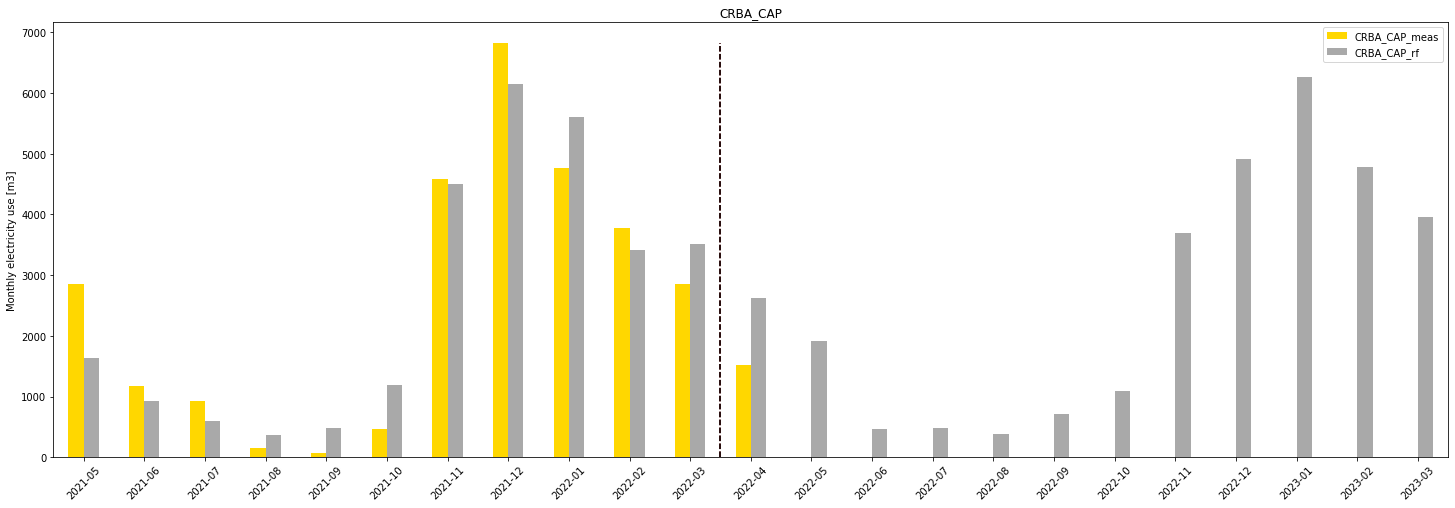

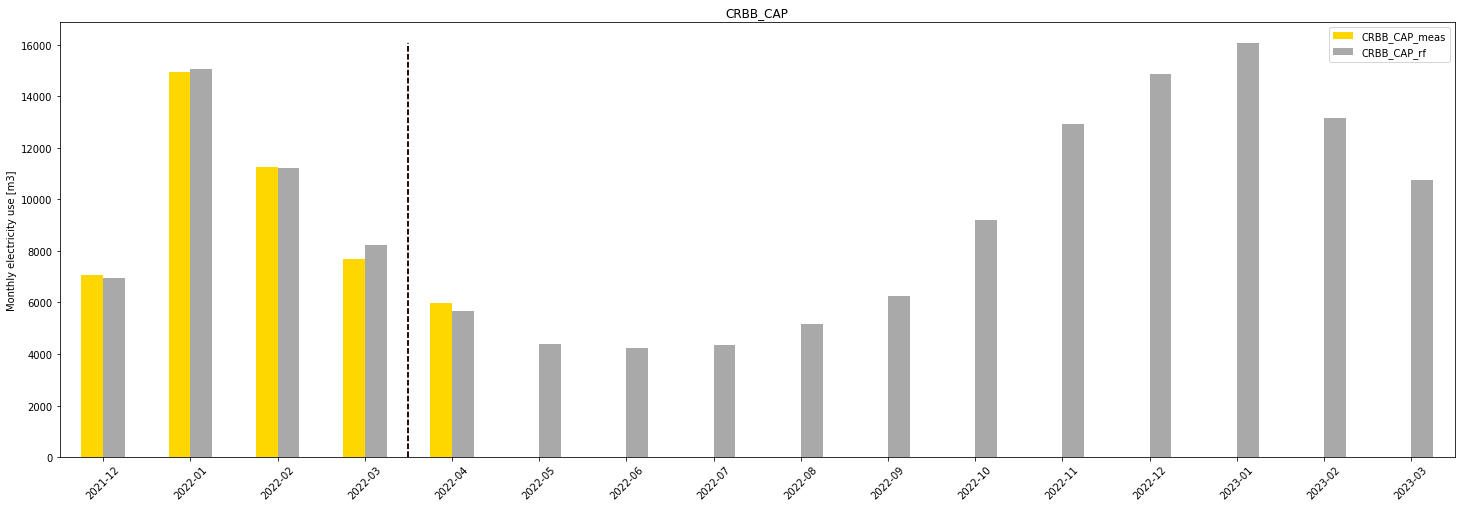

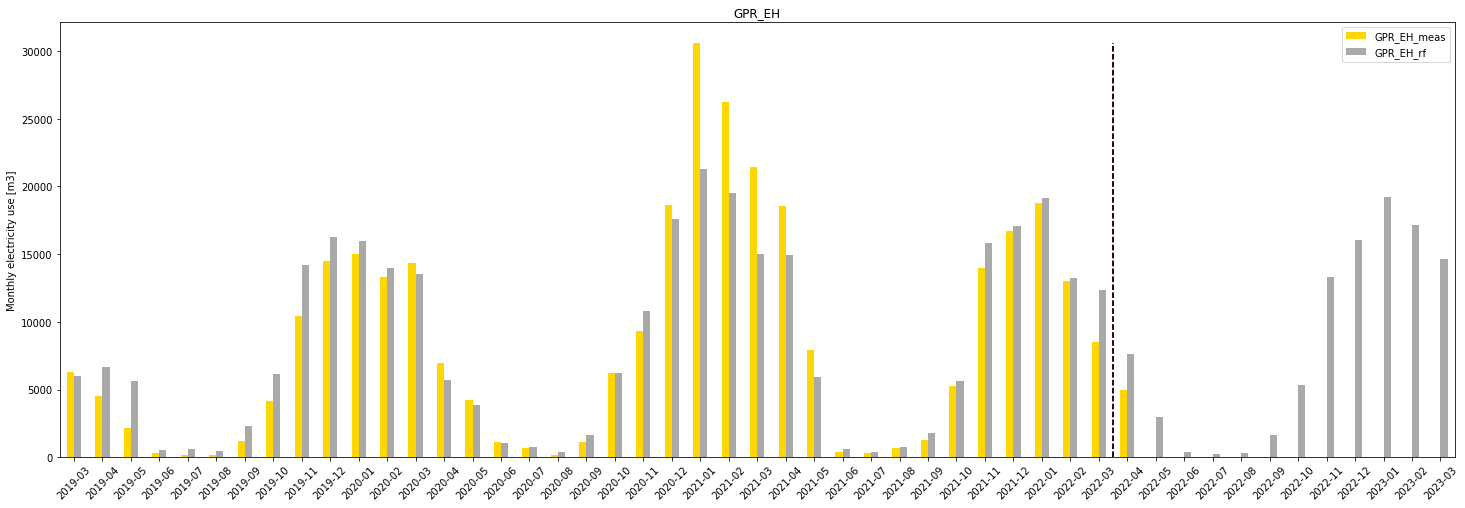

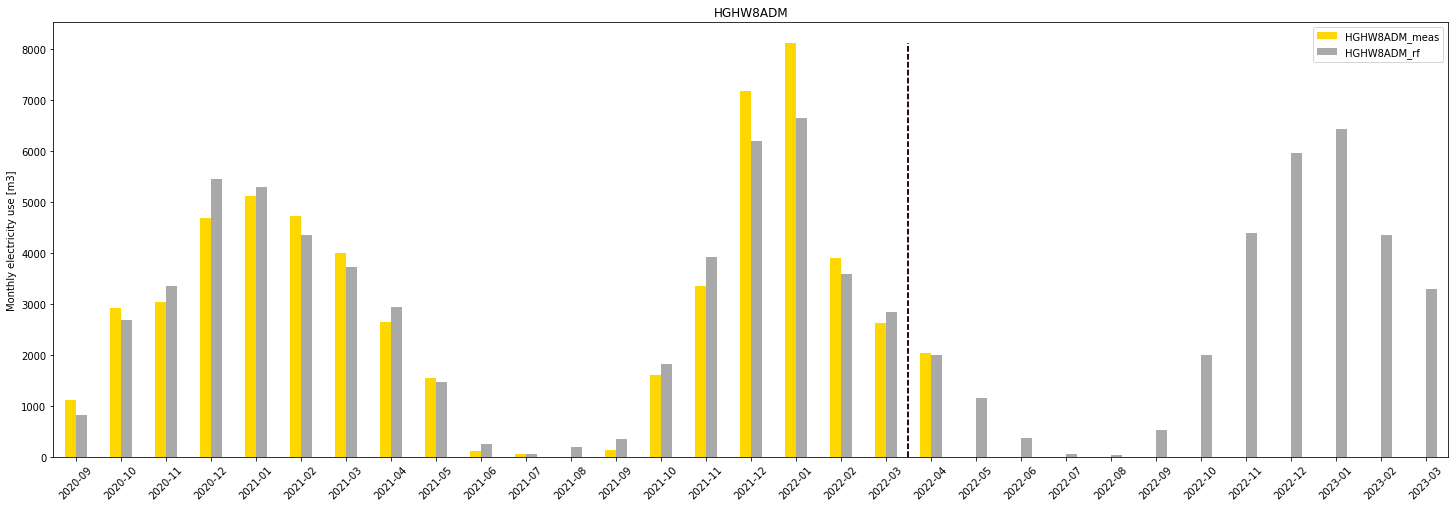

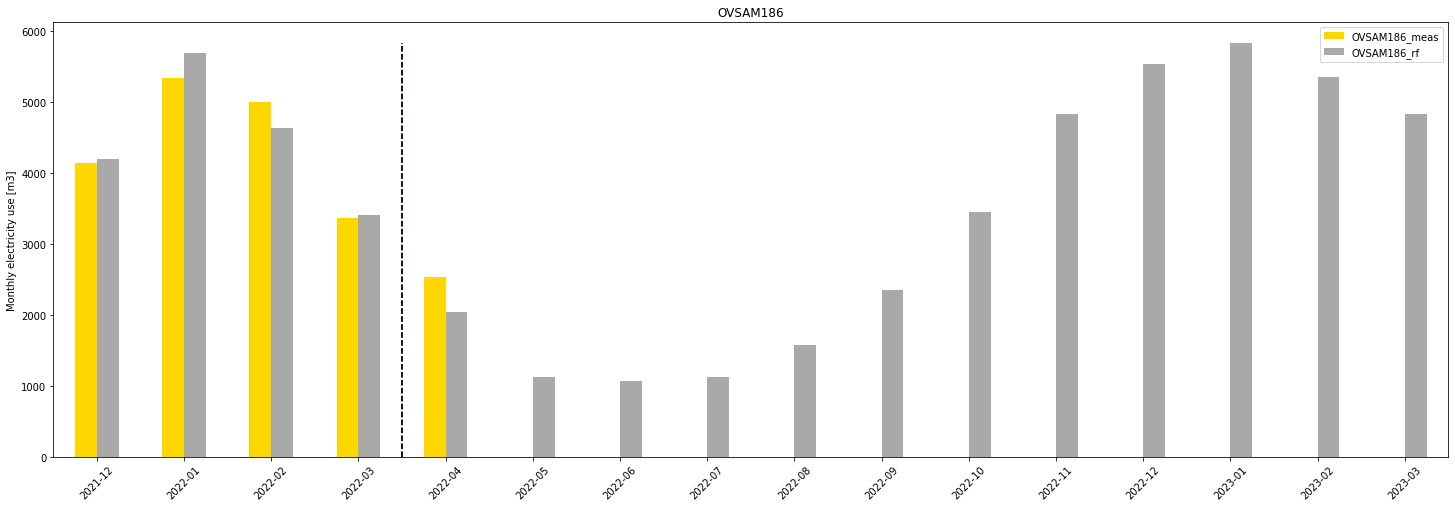

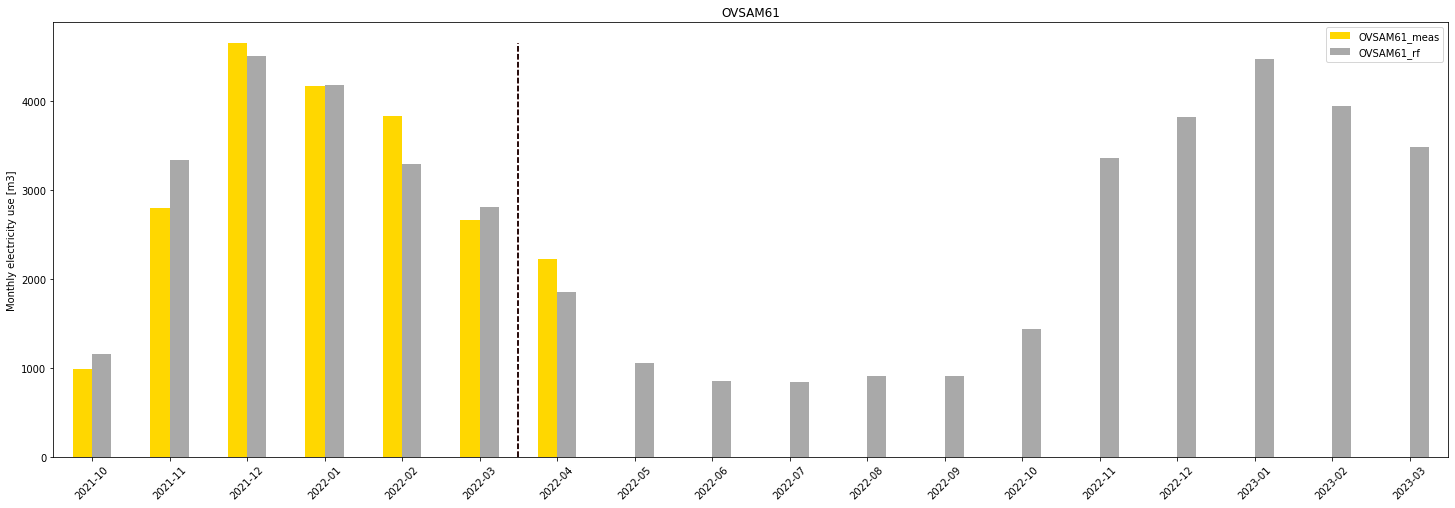

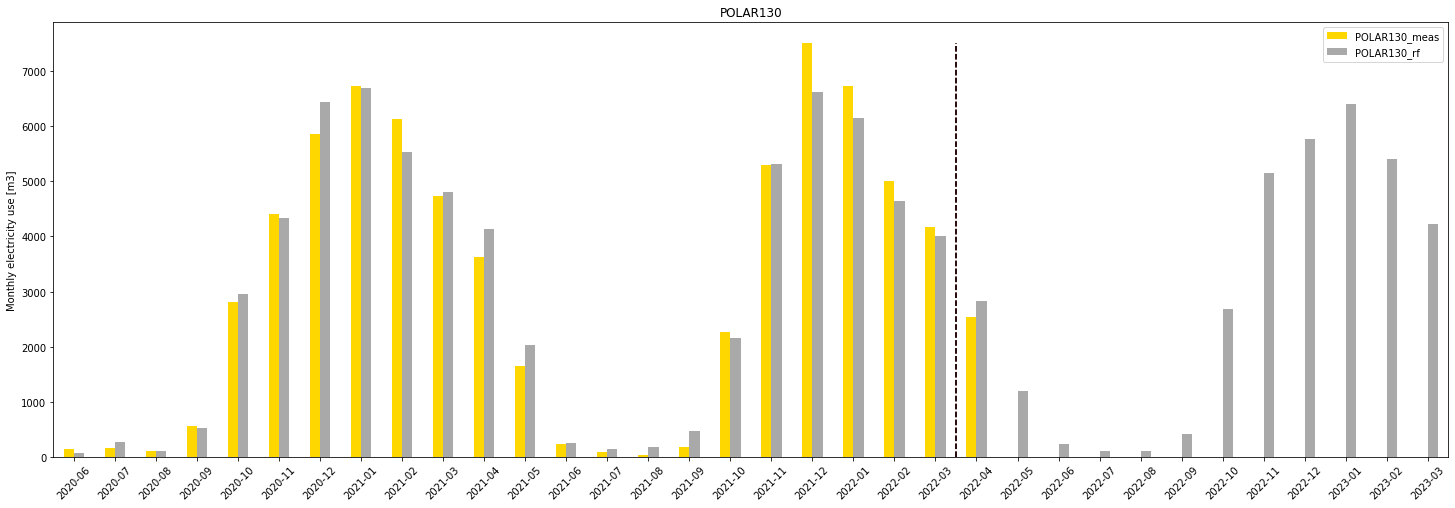

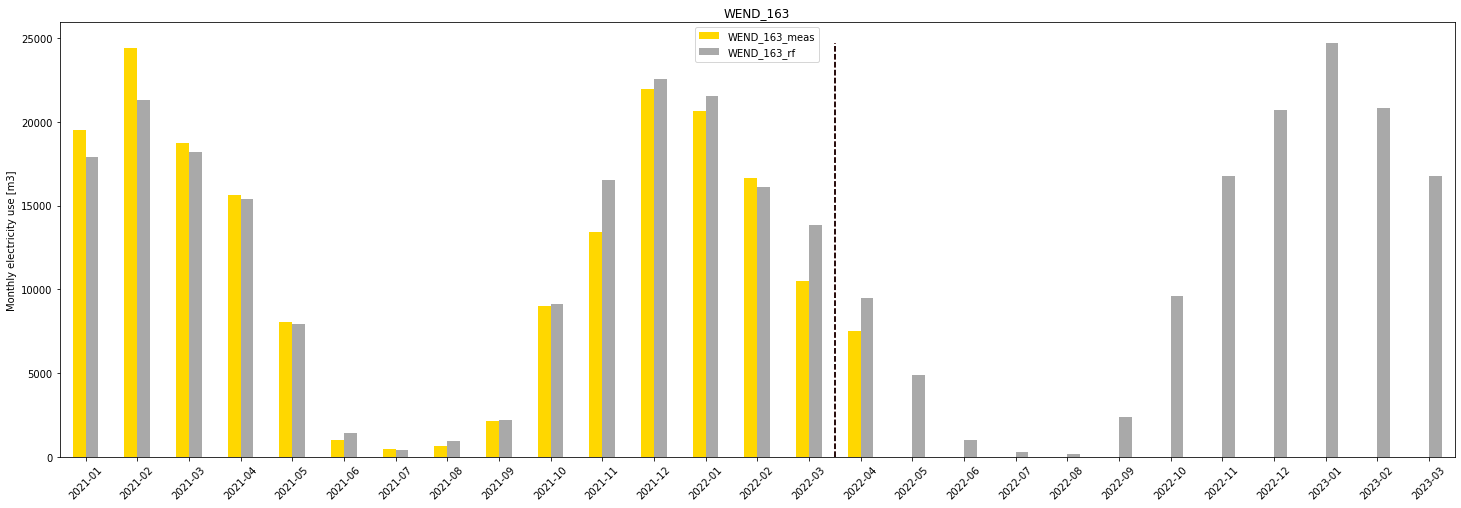

In [118]:
for building in gas_eans.index:
    start = forecast_periods.loc[building, 'start']
    end = gas_use_pred.index[-1]
    df_compare = pd.DataFrame(index=pd.date_range(start=start,
                                                     end=end,
                                                     freq=time_res))
    df_compare = df_compare.join(gas_use_meas[[building]])
    df_compare = df_compare.rename(columns={building:fr'{building}_meas'})
    df_compare = df_compare.join(gas_use_pred[[building+"_rf"]])
    #
    df_compare = df_compare.resample('m').sum()

    soc = socs[building]#.date()
    soc_pos = calc_date_pos_on_plot(df_compare_monthly=df_compare)
    train_end_pos = calc_date_pos_on_plot(df_compare_monthly=df_compare)
    #
    fig, ax = plt.subplots(figsize=(25, 8))
    df_compare.plot.bar(ax=ax, color=['gold', 'darkgrey'])
    #soc_mark = pd.Series(index=df_compare.index, data=np.nan)
    ax.set_xticklabels([x.strftime("%Y-%m") for x in df_compare.index], rotation=45)
    plt.vlines(x=train_end_pos, ymin=0, ymax=df_compare.max().max(), color='darkred', ls='--')
    plt.vlines(x=soc_pos, ymin=0, ymax=df_compare.max().max(), color='k', ls='--')
    patches = ax.patches
    patches_m = patches[0:int(len(patches)/2)]
    patches_p = patches[int(len(patches)/2):]

    plt.ylabel('Monthly electricity use [m3]')
    plt.title(building)
    plt.show(block=False)

In [119]:
metric_com_mae = pd.DataFrame(index=gas_eans.index)
regressors = ['rf', 'gb', 'xg']
for regressor in regressors:
    mae_range_percent = pd.Series()
    for building in gas_eans.index:
        models = os.listdir(f'MERIN_gas/data/trained_models/f_{regressor}') #change for RF, GB, XG
        if fr'trained_{building}.joblib' in models:
            grid_search = joblib.load(fr'MERIN_gas/data/trained_models/f_{regressor}/trained_{building}.joblib') #change for RF, GB, XG
            X_test = joblib.load(fr'MERIN_gas/data/trained_models/f_{regressor}/X_test_{building}.joblib') #change for RF, GB, XG
            y_test = joblib.load(fr'MERIN_gas/data/trained_models/f_{regressor}/y_test_{building}.joblib') #change for RF, GB, XG
        #
        # grid search already contains the re-trained model with the best parameters
        y_test_pred = grid_search.predict(X_test)

        #
        # calculating MAE and plotting test and pred_test
        mae = mean_absolute_error(y_true=y_test, y_pred=y_test_pred)
        # mae in percent of range
        mae_range_percent[building] = mae / y_test.max() * 100

        gas_use_train_build = gas_eans[building]

    metric_com_mae[regressor.upper()]=mae_range_percent

In [120]:
metric_com_rmse = pd.DataFrame(index=gas_eans.index)
regressors = ['rf', 'gb', 'xg']
for regressor in regressors:
    rmse_range_percent = pd.Series()
    for building in gas_eans.index:
        models = os.listdir(f'MERIN_gas/data/trained_models/f_{regressor}') #change for RF, GB, XG
        if fr'trained_{building}.joblib' in models:
            grid_search = joblib.load(fr'MERIN_gas/data/trained_models/f_{regressor}/trained_{building}.joblib') #change for RF, GB, XG
            X_test = joblib.load(fr'MERIN_gas/data/trained_models/f_{regressor}/X_test_{building}.joblib') #change for RF, GB, XG
            y_test = joblib.load(fr'MERIN_gas/data/trained_models/f_{regressor}/y_test_{building}.joblib') #change for RF, GB, XG
        #
        # grid search already contains the re-trained model with the best parameters
        y_test_pred = grid_search.predict(X_test)
        
        #calculating RMSE
        MSE = np.square(np.subtract(y_test, y_test_pred)).mean() 
        RMSE = math.sqrt(MSE)
        rmse_range_percent[building]=RMSE / y_test.max() * 100

    metric_com_rmse[regressor.upper()]=rmse_range_percent

In [121]:
en_mae = pd.DataFrame(index=gas_eans.index)
regressors = ['rf', 'gb', 'xg']
mae_range_percent = pd.Series()
master_test=pd.DataFrame()
master_test_pred=pd.DataFrame()

df1=pd.DataFrame()
df2=pd.DataFrame()
df3=pd.DataFrame()
df_c=pd.DataFrame()

df4=pd.DataFrame()
df5=pd.DataFrame()
df6=pd.DataFrame()
df_d=pd.DataFrame()

for building in gas_eans.index:
    for regressor in regressors:
        models = os.listdir(f'MERIN_gas/data/trained_models/f_{regressor}') #change for RF, GB, XG
        if fr'trained_{building}.joblib' in models:
            grid_search = joblib.load(fr'MERIN_gas/data/trained_models/f_{regressor}/trained_{building}.joblib') #change for RF, GB, XG
            X_test = joblib.load(fr'MERIN_gas/data/trained_models/f_{regressor}/X_test_{building}.joblib') #change for RF, GB, XG
            y_test = joblib.load(fr'MERIN_gas/data/trained_models/f_{regressor}/y_test_{building}.joblib') #change for RF, GB, XG
            #print(y_test) ##gives diffent dates, so needs to be investigated --> tried setting random seed during training
            y_test_pred = grid_search.predict(X_test)
            
            if regressor=="rf":
                df1=y_test.to_frame()
                df4=pd.DataFrame(y_test_pred, columns=[building])
                df1.reset_index(drop=True, inplace=True)
                df4.reset_index(drop=True, inplace=True)
            if regressor=="gb":
                df2=y_test.to_frame()
                df5=pd.DataFrame(y_test_pred, columns=[building])
                df2.reset_index(drop=True, inplace=True)
                df5.reset_index(drop=True, inplace=True)
            if regressor=="xg":
                df3=y_test.to_frame()
                df6=pd.DataFrame(y_test_pred, columns=[building])
                df3.reset_index(drop=True, inplace=True)
                df6.reset_index(drop=True, inplace=True)
                
    df_c=pd.concat([df1, df2, df3], axis=1)
    df_c.columns = [fr'{building}_rf', fr'{building}_gb',fr'{building}_xg']
    df_c[building+"_en"]=(df_c[building+"_rf"]+df_c[building+"_gb"]+df_c[building+"_xg"])/3
    del df_c[building+"_rf"]
    del df_c[building+"_gb"]
    del df_c[building+"_xg"]
    
    df_d=pd.concat([df4, df5, df6], axis=1)
    df_d.columns = [fr'{building}_rf', fr'{building}_gb',fr'{building}_xg']
    df_d[building+"_en"]=(df_d[building+"_rf"]+df_d[building+"_gb"]+df_d[building+"_xg"])/3
    
    del df_d[building+"_rf"]
    del df_d[building+"_gb"]
    del df_d[building+"_xg"]

    mae = mean_absolute_error(y_true=df_c[building+"_en"], y_pred=df_d[building+"_en"])
    
    mae_range_percent[building] = mae / df_c[building+"_en"].max() * 100

    en_mae['EN']=mae_range_percent
    

### MAEs

In [122]:
metric_com_mae['EN']=en_mae
print(metric_com_mae)
print("\n")
print("Average MAEs")
round(metric_com_mae.mean(), 5)

                   RF         GB         XG         EN
keyname_01                                            
CRBA_CAP     9.704338  11.618155  10.276496  11.424690
CRBB_CAP     4.950522   7.297940   6.541746   3.017345
GPR_EH       3.571378   5.101975   4.383078   6.749583
HGHW8ADM     7.979021   9.241185   7.489764   9.153224
OVSAM186    10.973297  15.916157  16.379952  10.370593
OVSAM61      8.325037  10.532168  10.951784  10.918097
POLAR130     4.126929   6.166283   4.389791   4.718420
WEND_163     6.158032   8.291508   6.032105   7.030069


Average MAEs


RF    6.97357
GB    9.27067
XG    8.30559
EN    7.92275
dtype: float64

In [123]:
en_rmse = pd.DataFrame(index=gas_eans.index)
regressors = ['rf', 'gb', 'xg']
rmse_range_percent = pd.Series()
master_test=pd.DataFrame()
master_test_pred=pd.DataFrame()

df1=pd.DataFrame()
df2=pd.DataFrame()
df3=pd.DataFrame()
df_c=pd.DataFrame()

df4=pd.DataFrame()
df5=pd.DataFrame()
df6=pd.DataFrame()
df_d=pd.DataFrame()

for building in gas_eans.index:
    for regressor in regressors:
        models = os.listdir(f'MERIN_gas/data/trained_models/f_{regressor}') #change for RF, GB, XG
        if fr'trained_{building}.joblib' in models:
            grid_search = joblib.load(fr'MERIN_gas/data/trained_models/f_{regressor}/trained_{building}.joblib') #change for RF, GB, XG
            X_test = joblib.load(fr'MERIN_gas/data/trained_models/f_{regressor}/X_test_{building}.joblib') #change for RF, GB, XG
            y_test = joblib.load(fr'MERIN_gas/data/trained_models/f_{regressor}/y_test_{building}.joblib') #change for RF, GB, XG
            #print(y_test) ##gives diffent dates, so needs to be investigated --> tried setting random seed during training
            y_test_pred = grid_search.predict(X_test)
            
            if regressor=="rf":
                df1=y_test.to_frame()
                df4=pd.DataFrame(y_test_pred, columns=[building])
                df1.reset_index(drop=True, inplace=True)
                df4.reset_index(drop=True, inplace=True)
            if regressor=="gb":
                df2=y_test.to_frame()
                df5=pd.DataFrame(y_test_pred, columns=[building])
                df2.reset_index(drop=True, inplace=True)
                df5.reset_index(drop=True, inplace=True)
            if regressor=="xg":
                df3=y_test.to_frame()
                df6=pd.DataFrame(y_test_pred, columns=[building])
                df3.reset_index(drop=True, inplace=True)
                df6.reset_index(drop=True, inplace=True)
                
    df_c=pd.concat([df1, df2, df3], axis=1)
    df_c.columns = [fr'{building}_rf', fr'{building}_gb',fr'{building}_xg']
    df_c[building+"_en"]=(df_c[building+"_rf"]+df_c[building+"_gb"]+df_c[building+"_xg"])/3
    del df_c[building+"_rf"]
    del df_c[building+"_gb"]
    del df_c[building+"_xg"]
    
    df_d=pd.concat([df4, df5, df6], axis=1)
    df_d.columns = [fr'{building}_rf', fr'{building}_gb',fr'{building}_xg']
    df_d[building+"_en"]=(df_d[building+"_rf"]+df_d[building+"_gb"]+df_d[building+"_xg"])/3
    

    MSE = np.square(np.subtract(df_c[building+"_en"], df_d[building+"_en"])).mean() 
    RMSE = math.sqrt(MSE)
    rmse_range_percent[building]=RMSE / df_c[building+"_en"].max() * 100
    
    en_rmse['EN']=rmse_range_percent
    

In [124]:
metric_com_rmse['EN']=en_rmse
print(metric_com_rmse)
print("\n")
print("Average RMSEs")
round(metric_com_rmse.mean(), 5)

                   RF         GB         XG         EN
keyname_01                                            
CRBA_CAP    14.488383  16.612051  15.347725  14.293586
CRBB_CAP     6.445585   9.054005   8.867062   3.905438
GPR_EH       6.538647   7.689807   7.770269   8.994990
HGHW8ADM    12.497531  13.452381  11.393767  12.404992
OVSAM186    15.407983  20.598781  20.287964  13.084955
OVSAM61     11.024731  12.826019  13.596072  13.633481
POLAR130     6.744842   8.612341   7.689748   6.404149
WEND_163     8.824116  10.590503   8.509756   8.833402


Average RMSEs


RF    10.24648
GB    12.42949
XG    11.68280
EN    10.19437
dtype: float64

### Individual Predictions

In [159]:
gas_use_pred = pd.DataFrame(index=features.index)
for building in gas_eans.index:

    city = cities[building]
    knmi_station = knmi_station_lookup[city]
    knmi_weather = weather[knmi_station]

    if knmi_station==240:
        features = pd.read_csv('features_240.csv', index_col=0, squeeze=True)
    if knmi_station==344:
        features = pd.read_csv('features_344.csv', index_col=0, squeeze=True)
    if knmi_station==370:
        features = pd.read_csv('features_370.csv', index_col=0, squeeze=True)
    if knmi_station==260:
        features = pd.read_csv('features_260.csv', index_col=0, squeeze=True)
    if knmi_station==275:
        features = pd.read_csv('features_275.csv', index_col=0, squeeze=True)

    features.index = pd.date_range('2011-01-01', periods=4473, freq='1D')
    del features['SQ'] #is only used for electricity
    features['dow'] = features.index.dayofweek
    #features['month'] = features.index.month
    X_pred = features
    # do the predictions
    models = os.listdir(f'MERIN_gas/data/trained_models/f_xg')
    if fr'trained_{building}.joblib' in models:
        grid_search = joblib.load(fr'MERIN_gas/data/trained_models/f_xg/trained_{building}.joblib')
    y_pred = grid_search.predict(X_pred)
    gas_use_pred[building] = y_pred

In [160]:
gas_use_pred=gas_use_pred.loc['2022-04-01':,]
gas_use_pred=gas_use_pred.resample('m').sum()
gas_use_pred.mean()*0.87

CRBA_CAP    2201.292969
CRBB_CAP    7469.811523
GPR_EH      7060.755371
HGHW8ADM    2153.157715
OVSAM186    2689.786865
OVSAM61     1906.268555
POLAR130    2551.114502
WEND_163    9015.070312
dtype: float32